In [ ]:
! pip install edward2

In [ ]:
! pip install gpflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from typing import Any, Callable, Dict, List, Optional, Union, Tuple

import os
import gc
import time
import pickle
import functools

import multiprocessing as mp

from google.colab import files
from google.colab import drive

In [ ]:
import numpy as np
import tensorflow as tf

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import edward2 as ed
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

dtype = tf.float32

In [ ]:
import gpflow as gpf

In [ ]:
import logging

logging.getLogger('tensorflow').setLevel(logging.ERROR)  # suppress pfor warnings

In [ ]:
# Verify versions.
print(f'TensorFlow version: {tf.__version__}. Expected: 2.7.0')
print(f'TensorFlow Probability version: {tfp.__version__}. Expected: 0.15.0')

TensorFlow version: 2.8.2. Expected: 2.7.0
TensorFlow Probability version: 0.16.0. Expected: 0.15.0


Enable GPU support by selecting `Edit > Notebook Settings > Hardware accelerator`

In [ ]:
tf.test.gpu_device_name()

''

# Functions

## High-level Wrapper Functions

In [ ]:
# @title Wrapper: generate_data_1d
OutcomeDistribution = Callable[[np.ndarray, np.ndarray], Any]

def generate_data_1d(N_train: int, 
                     N_base: int = 50, 
                     N_test: int = 1000,
                     y_dist: OutcomeDistribution = np.random.lognormal, 
                     seed: int = 0):
  """Generates 1D data for training ensemble model.
  
  Args:
    N_train: Number of extra training data points for ensemble model.
    N_base: Number of data points to train base model.
    N_test: Number of testing locations.
    y_dist: The data generating distribution of y that takes into two 
      vector-valued arguments (e.g., mean and variance).
    seed: Random seed
  
  Returns: 
    The (X, Y) data for base model, ensemble training, and ensemble testing.
  """
  np.random.seed(seed)
  tf.random.set_seed(seed)
  
  # Data ranges.
  train_range = (-3 * np.pi, 3 * np.pi)
  test_range = (-5 * np.pi, 5 * np.pi)

  # Build inputs X
  process_X_fn = lambda X: np.sort(X).astype(np.float32)

  X_base = process_X_fn(
      np.random.uniform(*train_range, size=(N_base, 1)))  # Data for training base model.
  X_train_extra = process_X_fn(
      np.random.uniform(*train_range, size=(N_train, 1)))  # Additional training data for ensemble.
  X_train = np.concatenate([X_base, X_train_extra])
  X_test = process_X_fn(
      np.random.uniform(*test_range, size=(N_test, 1)))  # Testing data covering whole feature space.
  X_test = np.sort(X_test, axis=0)  # Sort testing data for visualization.

  # True functions for moments.
  f_mean = lambda x: np.sin(x)
  f_stddev = lambda x: tf.exp(np.cos(x) - 1.0).numpy()

  # Compute loc and scale as functions of input X
  loc_base = f_mean(X_base)
  loc_train = f_mean(X_train)
  loc_test = f_mean(X_test)

  std_base = f_stddev(X_base)
  std_train = f_stddev(X_train)
  std_test = f_stddev(X_test)

  # Sample outputs Y and convert to float32 for TF compatibility.
  Y_base = y_dist(loc_base, std_base).astype(np.float32)
  Y_train = y_dist(loc_train, std_train).astype(np.float32)
  Y_test = y_dist(loc_test, std_test).astype(np.float32)

  # Compute true mean and variance.
  N_test_sample = 1000
  Y_test_sample = np.stack(
      [y_dist(loc_test, std_test) for _ in range(N_test_sample)])
  mean_test = np.mean(Y_test_sample, axis=0)

  return X_base, X_train, X_test, Y_base, Y_train, Y_test, mean_test

In [ ]:
# @title Examine "generate_data_1d"
gen_1d_result = generate_data_1d(N_train=100, N_base=50, N_test= 1000, y_dist= np.random.lognormal, seed = 0)
"""Generates 1D data for training ensemble model.
  
  Args:
    N_train: Number of extra training data points for ensemble model.
    N_base: Number of data points to train base model.
    N_test: Number of testing locations.
    y_dist: The data generating distribution of y that takes into two 
      vector-valued arguments (e.g., mean and variance).
    seed: Random seed
  
  Returns: 
    The (X, Y) data for base model, ensemble training, and ensemble testing.
  """
for dataset in gen_1d_result:
  print(dataset.shape)
  #print(dataset.ravel())
  # X_base, X_train, X_test, Y_base, Y_train, Y_test, mean_test

(50, 1)
(150, 1)
(1000, 1)
(50, 1)
(150, 1)
(1000, 1)
(1000, 1)


In [ ]:
# @title Wrapper: generate_data_2d
def generate_data_2d(N_train: int, 
                     N_base: int = 100, 
                     N_test: int = 5000,
                     y_dist: OutcomeDistribution = np.random.lognormal, 
                     seed: int = 0,
                     explicit_skewness: bool = False):
  """Generates 2D data for training ensemble model.
  
  Args:
    N_train: Number of extra training data points for ensemble model.
    N_base: Number of data points to train base model.
    N_test: Number of testing locations.
    y_dist: The data generating distribution of y that takes into two 
      vector-valued arguments (e.g., mean and variance).
    seed: Random seed.
    explicit_skewness: Whether to explicitly introduce skewness.
  
  Returns: 
    The (X, Y) data for base model, ensemble training, and ensemble testing.
  """
  np.random.seed(seed)
  tf.random.set_seed(seed)

  # Data ranges.
  train_range = (-np.pi, np.pi)
  test_range = (-1.25 * np.pi, 1.25 * np.pi)

  # Build inputs X
  sample_X = lambda low, high, n: np.random.uniform(low, high, size=(n, 2)).astype(np.float32)

  X_base = sample_X(*train_range, N_base)  # Data for training base model.
  X_train_extra = sample_X(*train_range, N_train)  # Additional training data for ensemble.
  X_train = np.concatenate([X_base, X_train_extra])
  X_test = sample_X(*test_range, N_test)  # Testing data covering whole feature space.

  f_mean = lambda x, mplr=1.5: bird(x[:,0:1]*mplr, x[:,1:2]*mplr)/5.  # mplr 1.25 to 1.5
  # f_std = lambda x, mplr=1.0: townsend(x[:,0:1]*mplr, x[:,1:2]*mplr)/5.
  f_std = lambda x, mplr=0.5: rosenbrock(x[:,0:1]*mplr, x[:,1:2]*mplr)  # mplr 0.25 to 0.5
  f_skew = lambda x, mplr=0.5: np.clip(
      townsend(x[:,0:1]*mplr, x[:,1:2]*mplr), a_min=1e-5, a_max=np.inf)

  # Generate mean, std and skewness surfaces.
  loc_base, loc_train, loc_test = map(f_mean, [X_base, X_train, X_test])
  std_base, std_train, std_test = map(f_std, [X_base, X_train, X_test])
  skew_base, skew_train, skew_test = map(f_skew, [X_base, X_train, X_test])

  # DEBUG: make std very small.
  std_base = 1e-3
  std_train = 1e-3
  std_test = 1e-3

  dist_args_base = (loc_base, std_base)
  dist_args_train = (loc_train, std_train)
  dist_args_test = (loc_test, std_test)

  if explicit_skewness:
    dist_args_base += (skew_base,)
    dist_args_train += (skew_train,)
    dist_args_test += (skew_test,)

  # Sample outputs Y and convert to float32 for TF compatibility.
  Y_base = y_dist(*dist_args_base).astype(np.float32)
  Y_train = y_dist(*dist_args_train).astype(np.float32)
  Y_test = y_dist(*dist_args_test).astype(np.float32)

  # Compute true mean and variance.
  N_test_sample = 1000
  Y_test_sample = np.stack(
      [y_dist(*dist_args_test) for _ in range(N_test_sample)])
  mean_test = np.mean(Y_test_sample, axis=0)
  # std_test = np.std(Y_test_sample, axis=0)

  return X_base, X_train, X_test, Y_base, Y_train, Y_test, mean_test

# Helper functions.
bird = lambda x, y: (  # Mishra's Bird function.
    np.sin(y) * np.exp((1.-np.cos(x))**2) + 
    np.cos(x) * np.exp((1.-np.sin(y))**2) + (x-y)**2)/100. - 1.
townsend = lambda x, y: ((  # (Modified) Townsend function.
    -(np.cos(x - 1.) * y)**2 - x * np.sin(3 * x + y)) + 10.)
rosenbrock = lambda x, y: (  # (Modified) Rosenbrock function.
    100. * (y - x**2)**2 + (1 - x)**2)/25.
goldstein = lambda x, y: (
    1. + (x + y + 1.)**2 * (19. - 14.*x + 3.*x**2 - 14.*y + 6*x*y + 3. * y**2)
    ) * (30. + (2.*x - 3.*y)**2 * (18. - 32.*x + 12.*x**2 + 48.*y - 36.*x*y + 27.*y**2))

In [ ]:
# @title Examine "generate_data_2d"
gen_2d_result = generate_data_2d(N_train= 500,  N_base= 100, N_test= 5000, y_dist= np.random.lognormal, 
                     seed= 0, explicit_skewness = False)
"""Generates 2D data for training ensemble model.
  
  Args:
    N_train: Number of extra training data points for ensemble model.
    N_base: Number of data points to train base model.
    N_test: Number of testing locations.
    y_dist: The data generating distribution of y that takes into two 
      vector-valued arguments (e.g., mean and variance).
    seed: Random seed.
    explicit_skewness: Whether to explicitly introduce skewness.
  
  Returns: 
    The (X, Y) data for base model, ensemble training, and ensemble testing.
  """
for dataset in gen_2d_result:
  print(dataset.shape)
  #print(dataset)
  # X_base, X_train, X_test, Y_base, Y_train, Y_test, mean_test

(100, 2)
(600, 2)
(5000, 2)
(100, 1)
(600, 1)
(5000, 1)
(5000, 1)


In [ ]:
# @title Wrapper: run_posterior_inference
def run_posterior_inference(model_dist: tfd.Distribution, 
                            Y: tf.Tensor, 
                            mcmc_config: Dict[str, Any], 
                            map_config: Optional[Dict[str, Any]] = None, 
                            model_config: Optional[Dict[str, Any]] = None,
                            initialize_from_map: bool = True):
  """Wrapper function for running MCMC with MAP initialization."""
  # Defines posterior log likelihood function, and also a 
  # randomly-sampled initial state from model prior.
  nchain = mcmc_config['nchain']
  init_state, target_log_prob_fn = prepare_mcmc(model_dist, Y, nchain=nchain)  
  
  if initialize_from_map:
    # Initializes at MAP, shape (num_chains, param_shape_0, param_shape_1).
    print('Running MAP:', end='\t')
    init_state = run_map(target_log_prob_fn=target_log_prob_fn, 
                         gp_config=model_config,
                         **map_config)

    init_state = tf.stack([init_state] * mcmc_nchain, axis=0)

  # Run MCMC, shape (param_shape_0, param_shape_1, num_chains).
  print('Running MCMC:', end='\t')
  gp_w_samples, _ = run_mcmc(init_state=init_state,
                             target_log_prob_fn=target_log_prob_fn,
                             **mcmc_config)  
  
  return gp_w_samples


In [ ]:
# @title Wrapper: run_base_models
def run_base_models(X_base, X_train, X_test, 
                    Y_base, Y_train, Y_test, kernels=None, 
                    num_train_steps=100, debug_mode=False):
  if kernels is None:
    kernels = [gpf.kernels.Matern52(lengthscales=0.5), 
               gpf.kernels.Polynomial(degree=3.), 
               gpf.kernels.ArcCosine(weight_variances=1., bias_variance=1.),
               gpf.kernels.Periodic(gpf.kernels.Exponential(lengthscales=2.))]

  n_models = len(kernels)
  kernel_names = [kernel.name for kernel in kernels]  

  models = [
    get_base_prediction(X_base, Y_base, X_train, kernel=k,
                        num_train_steps=num_train_steps, 
                        debug_mode=debug_mode) for k in kernels]
  base_preds_train = tf.stack([
    get_base_prediction(X_base, Y_base, X_train, model=m, debug_mode=debug_mode) for m in models], axis=-1)
  base_preds_test = tf.stack([
    get_base_prediction(X_base, Y_base, X_test, model=m, debug_mode=debug_mode) for m in models], axis=-1)
  
  return base_preds_train, base_preds_test, kernel_names


In [ ]:
# @title Wrapper: run_bma_model
def run_bma_model(X_train, X_test, Y_train,
                  base_preds_train, base_preds_test,
                  gp_lengthscale=1.,
                  gp_l2_regularizer=0.1,
                  y_noise_std=0.1,
                  map_step_size=0.1,
                  map_num_steps=10_000,
                  mcmc_step_size=0.1,
                  mcmc_num_steps=10_000,
                  mcmc_nchain=10,
                  mcmc_burnin=2_500,
                  mcmc_initialize_from_map=False,
                  n_samples_eval=1000,
                  n_samples_train=100,
                  n_samples_test=200,
                  return_mcmc_examples=True,
                  seed=0, 
                  debug_mode=False):
  # Assemble model configs.
  model_config = DEFAULT_GP_CONFIG.copy()
  map_config = DEFAULT_MAP_CONFIG.copy()
  mcmc_config = DEFAULT_MCMC_CONFIG.copy()

  model_config['lengthscale']=gp_lengthscale  
  model_config['l2_regularizer']=gp_l2_regularizer
  model_config['y_noise_std']=y_noise_std

  map_config['learning_rate']=map_step_size
  map_config['num_steps']=map_num_steps

  mcmc_config['nchain']=mcmc_nchain
  mcmc_config['burnin']=mcmc_burnin
  mcmc_config['step_size']=mcmc_step_size
  mcmc_config['num_steps']=mcmc_num_steps
  
  # Model prior.
  bma_prior, gp_config = bma_dist(X_train, 
                                  base_preds_train, 
                                  **model_config)

  model_config.update(gp_config)  
  if debug_mode:
    print(model_config)

  # Run MCMC estimation.
  weight_samples = run_posterior_inference(
      model_dist=bma_prior, 
      model_config=model_config,
      Y=Y_train, 
      map_config=map_config,
      mcmc_config=mcmc_config,
      initialize_from_map=mcmc_initialize_from_map)  
  
  del bma_prior
  # Get posterior sample for all model parameters.
  bma_joint_samples = make_bma_samples(X_test, None, 
                                       base_preds_test, 
                                       bma_weight_samples=weight_samples[0],
                                       bma_model_config=model_config, 
                                       n_samples=n_samples_eval, 
                                       seed=seed,
                                       y_samples_only=False,
                                       debug_mode=debug_mode)

  if return_mcmc_examples:
    # MCMC data for BNE training, shapes (num_samples * num_data, ...)
    means_train_mcmc, X_train_mcmc, Y_train_mcmc = make_bma_samples(
        X_train, Y_train, 
        base_preds_train, 
        bma_weight_samples=weight_samples[0],
        bma_model_config=model_config,
        n_samples=n_samples_train,
        seed=seed, 
        prepare_mcmc_training=True,
        debug_mode=debug_mode)

    # MCMC data for BNE testing, shape (num_samples, num_data, num_output).
    means_test_mcmc = make_bma_samples(X_test, None, 
                                       base_preds_test, 
                                       bma_weight_samples=weight_samples[0],
                                       bma_model_config=model_config,
                                       n_samples=n_samples_test,
                                       seed=seed,
                                       debug_mode=debug_mode)
    
    return (bma_joint_samples, X_train_mcmc, Y_train_mcmc, 
            means_train_mcmc, means_test_mcmc)
    
  return bma_joint_samples

In [ ]:
# @title Wrapper: run_bne_model
BNE_MOMENT_TYPES = ('none', 'mean', 'variance', 'skewness')
def run_bne_model(X_train: tf.Tensor,
                  Y_train: tf.Tensor,
                  X_test: tf.Tensor, 
                  base_model_samples_train: tf.Tensor,
                  base_model_samples_test: tf.Tensor,
                  moment_mode: str = 'none',
                  gp_lengthscale: float = 1., 
                  gp_l2_regularizer: float = 10., 
                  variance_prior_mean: float = 0., 
                  skewness_prior_mean: float = 0.,
                  map_step_size: float = 5e-3,
                  map_num_steps: float = 10_000,
                  mcmc_step_size: float = 1e-2,
                  mcmc_num_steps: float = 10_000,
                  mcmc_burnin: int = 2_500,
                  mcmc_nchain: int = 10,
                  mcmc_initialize_from_map: bool = False,
                  seed: int = 0,
                  debug_mode: bool = False):
  """Runs the full BNE model end-to-end.

  This function performs end-to-end estimation of BNE model. It supports four 
  modes as determined by `moment_mode`:

    * 'none': Estimate a constant-variance model y ~ N(m(x), scale).
    * 'mean': Estimate a residual process model y ~ N(m(x) + r(x), scale).
    * 'variance': Estimate a heterogeneous residual process model 
        y ~ N(m(x) + r(x), scale(x)).
    * 'skewness': Estimate a heterogeneous residual process model with 
        skewness y ~ EMG(m(x) + r(x), scale(x), rate(x)).

  Args:
    X_train: The training features (num_train, num_dim).
    Y_train: The training responses (num_train, 1).
    X_test: The testing features (num_test, num_dim).
    base_model_samples_train: The posterior samples m(x) from the base ensemble 
      model at train locations, shape (num_train, 1).
    base_model_samples_test: The posterior samples m(x) from the base ensemble 
      model at test locations, shape (num_test, 1).
    moment_mode: The highest moment for the BNE model to estimate. 
      Must be one of ('none', 'mean', 'variance', 'skewness').
    gp_lengthscale:  length scale for model Gaussian processes.
    gp_l2_regularizer: l2_regularizer for model Gaussian processes.
    bne_variance_prior_mean: Prior mean to variance parameter.  
    bne_skewness_prior_mean: Prior mean to skewness parameter.
    map_step_size: Step size for MAP optimization.
    map_num_steps: Number of train steps for MAP optimization. 
    mcmc_step_size: Step size for HMC sampling
    mcmc_num_steps: Number of train steps for HMC sampling.
    seed: The seed for generating posterior samples.

  Returns:
    A dictionary with model parameters and its MCMC samples. 
  """
  # Prepares model and estimation configs.
  gp_config = DEFAULT_GP_CONFIG.copy()
  model_config = DEFAULT_BNE_CONFIG.copy()
  map_config = DEFAULT_MAP_CONFIG.copy()
  mcmc_config = DEFAULT_MCMC_CONFIG.copy()

  gp_config['lengthscale'] = gp_lengthscale
  gp_config['l2_regularizer'] = gp_l2_regularizer

  model_config['estimate_mean'] = moment_mode in ('mean', 'variance', 'skewness')
  model_config['estimate_variance'] = moment_mode in ('variance', 'skewness')
  model_config['estimate_skewness'] = moment_mode in ('skewness',)
  model_config['variance_prior_mean'] = variance_prior_mean
  model_config['skewness_prior_mean'] = skewness_prior_mean
  model_config.update(gp_config)

  map_config['learning_rate'] = map_step_size
  map_config['num_steps']=map_num_steps

  mcmc_config['nchain'] = mcmc_nchain
  mcmc_config['burnin'] = mcmc_burnin
  mcmc_config['step_size'] = mcmc_step_size
  mcmc_config['num_steps'] = mcmc_num_steps

  # Constructs prior distribution.
  bne_prior, bne_gp_config = bne_model_dist(X_train,
                                            mean_preds=base_model_samples_train,
                                            **model_config)

  model_config.update(bne_gp_config)

  # Estimates GP weight posterior using MCMC.
  gp_weight_samples = run_posterior_inference(
      model_dist=bne_prior,
      model_config=bne_gp_config,
      Y=Y_train,
      map_config=map_config,
      mcmc_config=mcmc_config,
      initialize_from_map=mcmc_initialize_from_map)
  
  # Generates the posterior sample for all model parameters. 
  joint_samples = make_bne_samples(X_test,
                                   mean_preds=base_model_samples_test,
                                   bne_model_config=model_config,
                                   bne_weight_samples=gp_weight_samples[0],
                                   seed=seed,
                                   debug_mode=debug_mode)
  del bne_prior  
  return joint_samples

## Core Model Functions

In [ ]:
# @title Distribution: ExponentiallyModifiedGaussian
from tensorflow_probability.python.bijectors import identity as identity_bijector
from tensorflow_probability.python.bijectors import softplus as softplus_bijector
from tensorflow_probability.python.distributions import distribution
from tensorflow_probability.python.distributions import exponential as exponential_lib
from tensorflow_probability.python.distributions import normal as normal_lib
from tensorflow_probability.python.internal import assert_util
from tensorflow_probability.python.internal import dtype_util
from tensorflow_probability.python.internal import parameter_properties
from tensorflow_probability.python.internal import reparameterization
from tensorflow_probability.python.internal import samplers
from tensorflow_probability.python.internal import special_math
from tensorflow_probability.python.internal import tensor_util
from tensorflow_probability.python.math import generic as tfp_math


class ExponentiallyModifiedGaussian(
    distribution.AutoCompositeTensorDistribution):
  """Exponentially modified Gaussian distribution.
  #### Mathematical details
  The exponentially modified Gaussian distribution is the sum of a normal
  distribution and an exponential distribution.
  ```none
  X ~ Normal(loc, scale)
  Y ~ Exponential(rate)
  Z = X + Y
  ```
  is equivalent to
  ```none
  Z ~ ExponentiallyModifiedGaussian(loc, scale, rate)
  ```
  #### Examples
  ```python
  tfd = tfp.distributions
  # Define a single scalar ExponentiallyModifiedGaussian distribution
  dist = tfd.ExponentiallyModifiedGaussian(loc=0., scale=1., rate=3.)
  # Evaluate the pdf at 1, returing a scalar.
  dist.prob(1.)
  ```
  """

  def __init__(self,
               loc,
               scale,
               rate,
               validate_args=False,
               allow_nan_stats=True,
               name='ExponentiallyModifiedGaussian'):
    """Construct an exponentially-modified Gaussian distribution.
    The Gaussian distribution has mean `loc` and stddev `scale`,
    and Exponential distribution has rate parameter `rate`.
    The parameters `loc`, `scale`, and `rate` must be shaped in a way that
    supports broadcasting (e.g. `loc + scale + rate` is a valid operation).
    Args:
      loc: Floating-point `Tensor`; the means of the distribution(s).
      scale: Floating-point `Tensor`; the stddevs of the distribution(s). Must
        contain only positive values.
      rate: Floating-point `Tensor`; the rate parameter for the exponential
        distribution.
      validate_args: Python `bool`, default `False`. When `True` distribution
        parameters are checked for validity despite possibly degrading runtime
        performance. When `False` invalid inputs may silently render incorrect
        outputs.
      allow_nan_stats: Python `bool`, default `True`. When `True`, statistics
        (e.g., mean, mode, variance) use the value "`NaN`" to indicate the
        result is undefined. When `False`, an exception is raised if one or more
        of the statistic's batch members are undefined.
      name: Python `str` name prefixed to Ops created by this class.
    Raises:
      TypeError: if `loc`, `scale`, and `rate` are not all the same `dtype`.
    """
    parameters = dict(locals())
    with tf.name_scope(name) as name:
      dtype = dtype_util.common_dtype([loc, scale, rate], dtype_hint=tf.float32)
      self._loc = tensor_util.convert_nonref_to_tensor(
          loc, dtype=dtype, name='loc')
      self._scale = tensor_util.convert_nonref_to_tensor(
          scale, dtype=dtype, name='scale')
      self._rate = tensor_util.convert_nonref_to_tensor(
          rate, dtype=dtype, name='rate')
      super(ExponentiallyModifiedGaussian, self).__init__(
          dtype=dtype,
          reparameterization_type=reparameterization.FULLY_REPARAMETERIZED,
          validate_args=validate_args,
          allow_nan_stats=allow_nan_stats,
          parameters=parameters,
          name=name)

  @staticmethod
  def _param_shapes(sample_shape):
    return dict(
        zip(('loc', 'scale', 'rate'),
            ([tf.convert_to_tensor(sample_shape, dtype=tf.int32)] * 3)))

  @classmethod
  def _parameter_properties(cls, dtype, num_classes=None):
    return dict(
        loc=parameter_properties.ParameterProperties(),
        scale=parameter_properties.ParameterProperties(
            default_constraining_bijector_fn=(
                lambda: softplus_bijector.Softplus(low=dtype_util.eps(dtype)))),
        rate=parameter_properties.ParameterProperties(
            default_constraining_bijector_fn=(
                lambda: softplus_bijector.Softplus(low=dtype_util.eps(dtype)))))

  @property
  def loc(self):
    """Distribution parameter for the mean of the normal distribution."""
    return self._loc

  @property
  def scale(self):
    """Distribution parameter for standard deviation of the normal distribution."""
    return self._scale

  @property
  def rate(self):
    """Distribution parameter for rate parameter of exponential distribution."""
    return self._rate

  def _event_shape_tensor(self):
    return tf.constant([], dtype=tf.int32)

  def _event_shape(self):
    return tf.TensorShape([])

  def _sample_n(self, n, seed=None):
    normal_seed, exp_seed = samplers.split_seed(seed, salt='emg_sample')
    # need to make sure component distributions are broadcast appropriately
    # for correct generation of samples
    loc = tf.convert_to_tensor(self.loc)
    rate = tf.convert_to_tensor(self.rate)
    scale = tf.convert_to_tensor(self.scale)
    batch_shape = self._batch_shape_tensor(loc=loc, scale=scale, rate=rate)
    loc_broadcast = tf.broadcast_to(loc, batch_shape)
    rate_broadcast = tf.broadcast_to(rate, batch_shape)
    normal_dist = normal_lib.Normal(loc=loc_broadcast, scale=scale)
    exp_dist = exponential_lib.Exponential(rate_broadcast)
    x = normal_dist.sample(n, normal_seed)
    y = exp_dist.sample(n, exp_seed)
    return x + y

  def _log_prob(self, x):
    loc = tf.convert_to_tensor(self.loc)
    rate = tf.convert_to_tensor(self.rate)
    scale = tf.convert_to_tensor(self.scale)
    two = dtype_util.as_numpy_dtype(x.dtype)(2.)
    z = (x - loc) / scale
    w = rate * scale
    return (tf.math.log(rate) + w / two * (w - 2 * z) +
            special_math.log_ndtr(z - w))

  def _log_cdf(self, x):
    rate = tf.convert_to_tensor(self.rate)
    scale = tf.convert_to_tensor(self.scale)
    x_centralized = x - self.loc
    u = rate * x_centralized
    v = rate * scale
    vsquared = tf.square(v)
    return tfp_math.log_sub_exp(
        special_math.log_ndtr(x_centralized / scale),
        -u + vsquared / 2. + special_math.log_ndtr((u - vsquared) / v))

  def _mean(self):
    return tf.broadcast_to(
        self.loc + 1 / self.rate, self._batch_shape_tensor())

  def _variance(self):
    return tf.broadcast_to(
        tf.square(self.scale) + 1 / tf.square(self.rate),
        self._batch_shape_tensor())

  def _parameter_control_dependencies(self, is_init):
    assertions = []

    if is_init:
      try:
        self._batch_shape()
      except ValueError:
        raise ValueError(
            'Arguments `loc`, `scale`, and `rate` must have compatible shapes; '
            'loc.shape={}, scale.shape={}, rate.shape={}.'.format(
                self.loc.shape, self.scale.shape, self.rate.shape))
      # We don't bother checking the shapes in the dynamic case because
      # all member functions access both arguments anyway.

    if not self.validate_args:
      assert not assertions  # Should never happen.
      return []

    if is_init != tensor_util.is_ref(self.scale):
      assertions.append(assert_util.assert_positive(
          self.scale, message='Argument `scale` must be positive.'))

    if is_init != tensor_util.is_ref(self.rate):
      assertions.append(assert_util.assert_positive(
          self.rate, message='Argument `rate` must be positive.'))

    return assertions

  def _default_event_space_bijector(self):
    return identity_bijector.Identity(validate_args=self.validate_args)


In [ ]:
# @title Model: Random Feature.

def make_random_feature(X: tf.Tensor, 
                        lengthscale: float = 1., 
                        hidden_units: int = 512, 
                        seed: int = 0, 
                        return_Wb: bool = False, 
                        **unused_kwargs) -> Union[tf.Tensor, Tuple[tf.Tensor]]:
  """Makes random feature for scalable RBF kernel approximation.

  Given data point x with shape (P, 1), the random feature is computed as 
  
              Phi(x) = sqrt(2/M) * cos(Wx + b), where

  W and b are untrainable random weights (shape [M, P]) and biases 
  (shape [M, 1]) initialized from Gaussian and uniform distribution, 
  respectively. Here M is the number of hidden units.
  
  Args:
    X: The input data of shape (batch_size, feature_dim).
    lengthscale: The length scale of RBF kernel.
    hidden_units: The number of hidden units used to approximate the exact 
      Gaussian process posterior. Higher number leads to more exact 
      approximation, although it doesn't necessarily leads to better prediction
      performance.
    seed: The random seed used to generate the random features.
    return_Wb: Whether to return the weights and bias (W, b) of the random 
      feature mapping cos().
    unused_kwargs: Unused keyword arguments for signiture consistency with other
      prior functions.

  Returns:
    Random feature Phi(X) with shape (batch_size, hidden_units). Or 
    the random weights and biases if return_Wb=True.
  """
  del unused_kwargs

  # Configure shapes.
  feature_dim = tf.shape(X)[1]
  W_shape = (feature_dim, hidden_units)
  b_shape = (hidden_units,)

  # Apply lengthscale.
  X = tf.convert_to_tensor(X, dtype=dtype)
  lengthscale = tf.convert_to_tensor(lengthscale, dtype=dtype)
  
  X = X / lengthscale

  # Sample random features.
  tf.random.set_seed(seed)
  W_dist = ed.initializers.OrthogonalRandomFeatures(stddev=1.)
  b_dist = tf.initializers.RandomUniform(0, 2*np.pi)
  W = W_dist(W_shape).numpy()
  b = b_dist(b_shape).numpy()

  multiplier = tf.sqrt(2./hidden_units)
  random_feature = multiplier * tf.math.cos(tf.matmul(X, W) + b)
  
  if return_Wb:
    return W, b
  return random_feature


In [ ]:
# @title Model: Gaussian Process.

def rfgp_dist(inputs: tf.Tensor,
              units: int = 1,
              hidden_units: int = 128,               
              lengthscale: float = 1., 
              l2_regularizer: float = 1., 
              y_noise_std: float = 0.1,
              seed: int = 0,
              posterior_mode: bool = False,
              posterior_sample: Optional[tf.Tensor] = None,
              return_joint_dist: bool = True,
              verbose: bool = False
              ) -> Tuple[Union[tfd.Distribution, List[tfd.Distribution]], 
                         Dict[str, Any]]:
  """Specifies a random-feature-based Gaussian process (RFGP) distribution.
  
  Given random feature mapping Phi(x), a Gaussian process prior 
  f ~ GaussianProcess can be expressed as:

      f(x) ~ matmul(Phi(x), W);   W i.i.d. ~ Normal(0, s)

  where W is a i.i.d. Normal prior with shape (num_hidden_units, units), and 
  its standard deviation s serves as a regularizer to control the smoothness of
  f(x) (similar to the l2 penalty in Ridge regression).

  This function also allow user to specify a Gaussian process regression model
  (by setting y_noise_std>0), that is, it will specify a prior model like below:

      y | f ~ N(f(x), y_noise_std);   f ~ GaussianProcess (as specified above)

  Args:
    inputs: Input data of size (batch_size, feature_dim).
    units: Number of outputs from the Gaussian process.
    hidden_units: The number of hidden units used to approximate the exact 
      Gaussian process posterior. Higher number leads to more exact 
      approximation, although it doesn't necessarily leads to better prediction
      performance.
    lengthscale: The length scale of RBF kernel.
    l2_regularizer: The L2 regularizer to Gaussian process prior, which is 
      effectively the inverse standard deviation of the prior distribution 
      of beta.
    y_noise_std: The standard deviation of the output y given f. If -1 then 
      y | f is a deterministic distribution (i.e., y = f).
    seed: The random seed used to generate the random features.
    posterior_mode: Whether to specify the posterior distribution of the 
      Gaussian process instead of the prior distribution. If `True`, then 
      the distribution of `beta` is specified as a sampler from the posterior 
      sample.
    posterior_sample: The posterior sample of `beta` with dimension 
      (num_mcmc_sample, hidden_units, units) or 
      (hidden_units, units, num_mcmc_sample). Must be provided if `posterior_mode=True`.
    return_joint_dist: If True, return a tfd.Distribution object which 
      represents the joint distribution of the model random variables [W, y], 
      which can be used for MCMC sampling. If False, return a list of random
      variables which can be used as a building block for more complex models,
      and also add the model random features Phi(X) to the model_config.

  Returns:
    joint_dist: The random variables in the Gaussian process prior [W, y].
    model_config: A dictionary of keyword arguments to make_random_feature.
  """
  feature_dim = tf.shape(inputs)[1]
  # Latent random features.
  random_features = make_random_feature(inputs, 
                                        lengthscale=lengthscale, 
                                        hidden_units=hidden_units, 
                                        seed=seed)
    
  # Parameter Distributions.
  W_dist = tfd.Normal(loc=tf.zeros(shape=(hidden_units, units)), 
                      scale=1./l2_regularizer)
  if posterior_mode:
    # If in posterior mode, defines W_dist as the Empirical distribution 
    # constructed from the posterior samples.
    if (posterior_sample.shape[1] == hidden_units and 
        posterior_sample.shape[2] == units):
      # Convert the posterior_sample shape from  
      # (num_sample, hidden_units, output_units) to
      # (hidden_units, output_units, num_sample).
      posterior_sample = tf.transpose(posterior_sample, [1, 2, 0])

    sample_hidden_dim = posterior_sample.shape[0]
    sample_output_dim = posterior_sample.shape[1]
    num_sample = posterior_sample.shape[2]

    if (sample_hidden_dim != hidden_units or 
        sample_output_dim != units or 
        len(posterior_sample.shape) != 3):
      raise ValueError(
          "Expect posterior_sample shape to be "
          f"[num_sample, hidden_units({hidden_units}),units({units})] or "
          f"[hidden_units({hidden_units}),units({units}), num_sample]. Got "
          f"{posterior_sample.shape}.")

    if verbose:
      print(f"Constructing posterior from {num_sample} samples.")
    W_dist = tfd.Empirical(posterior_sample, event_ndims=0)
  
  # Outcome Distributions.
  if y_noise_std > 0.:
    y_dist = lambda gp_weights: tfd.Normal(
        loc=tf.linalg.matmul(random_features, gp_weights), scale=y_noise_std)
  else:
    y_dist = lambda gp_weights: tfd.Deterministic(
        loc=tf.linalg.matmul(random_features, gp_weights))
        
  joint_dist = dict(gp_weights=W_dist, y=y_dist)

  if return_joint_dist:
    joint_dist = tfd.JointDistributionNamedAutoBatched(joint_dist)

  # Model config.
  model_config = dict(units=units,
                      hidden_units=hidden_units,                             
                      lengthscale=lengthscale, 
                      l2_regularizer=l2_regularizer, 
                      y_noise_std=y_noise_std,
                      seed=seed)
  
  if not return_joint_dist:
    model_config['random_features'] = random_features

  return joint_dist, model_config

In [ ]:
# @title Model: Bayesian Model Averaging.
def bma_dist(inputs: tf.Tensor, 
             base_model_preds: tf.Tensor, 
             y_noise_std: float = 0.1,
             posterior_mode: bool = False,
             posterior_sample: Optional[tf.Tensor] = None,
             sample_intermediate_variables: bool = False,
             return_joint_dist: bool = True,
             debug_mode: bool = False,
             **gp_kwargs):
  """Specifies an adaptive Bayesian model averaging (BMA) model.
  
  This function specifies an adaptive ensemble model with model weights 
  parameterized by Gaussian processes:

      y | f ~ N(m(x), y_noise_std)  where  m = sum_k p_k(x) * m_k(x),       
      
  where m_k(x) are base model predictions, and p_k's are adaptive ensemble 
  weights specified as:

      [p_1(x), ..., p_K(x)] = softmax([f_1(x), ..., f_K(x)])
      [f_1, ..., f_K]  ~ i.i.d.  GaussianProcess

  Args:
    inputs: Input data of size (batch_size, feature_dim).
    base_model_preds: Base model predictions of shape (batch_size, num_base_models).
    y_noise_std: The standard deviation of the output distribution y | f.
    posterior_mode: Whether to specify the posterior distribution of the 
      Gaussian process instead of the prior distribution. If `True`, then 
      the distribution of `beta` is specified as a sampler from the posterior 
      sample.
    posterior_sample: The posterior sample of `beta` with dimension 
      (hidden_units, units, num_mcmc_sample). Must be provided if 
      `posterior_mode=True`.
    sample_intermediate_variables: Whether to generate posterior samples of
      intermediate variables for model understanding when `posterior_mode=True`.
    return_joint_dist: If True, return a tfd.Distribution object which 
      represents the joint distribution of the model random variables [W, y], 
      which can be used for MCMC sampling. If False, return a list of random
      variables which can be used as a building block for more complex models,
      and also add the model random features Phi(X) to the model_config.

  Returns:
    joint_dist: The random variables in the Gaussian process prior [W, y].
    model_config: A dictionary of keyword arguments to make_random_feature.
  """
  num_model_data, num_model = base_model_preds.shape
  num_input_data, num_input_features = inputs.shape

  if num_model_data != num_input_data:
    raise ValueError(
        f'Number of data points in input data ({num_input_data}) and in model '
        f'predictions ({num_model_data}) should be equal.')

  # Specifies Gaussian process priors for ensemble weights.
  gp_kwargs.pop('y_noise_std', None)
  gp_kwargs.pop('units', None)
  gp_dists, gp_config = rfgp_dist(
      inputs, 
      units=num_model, 
      posterior_mode=posterior_mode,
      posterior_sample=posterior_sample,
      return_joint_dist=False,
      verbose=debug_mode,
      **gp_kwargs)

  gp_features = gp_config.pop('random_features')
  gp_weight_dist = gp_dists["gp_weights"]  

  # Specifies Bayesian model averaging model.
  joint_dist = dict()

  joint_dist["gp_weights"] = gp_weight_dist
  if posterior_mode and sample_intermediate_variables:
    # Generates posterior of all intermediate variables.
    joint_dist["gps"] = lambda gp_weights: tfd.Deterministic(
        loc=build_ensemble_weight_logits(gp_weights, gp_features))
    joint_dist["ensemble_weights"] = lambda gps: tfd.Deterministic(
        loc=build_ensemble_weights(gps))
    joint_dist["y"] = lambda ensemble_weights: tfd.Normal(
        loc=ensemble_prediction(ensemble_weights, base_model_preds), 
        scale=y_noise_std)
  else:
    # Use collapsed joint distribution for easy MCMC sampling.
    joint_dist["y"] = lambda gp_weights: tfd.Normal(
        loc=ensemble_mean(gp_weights, base_model_preds, gp_features), 
        scale=y_noise_std)
  
  if return_joint_dist:
    joint_dist = tfd.JointDistributionNamedAutoBatched(joint_dist) 
  
  # Store model config.
  model_config = gp_config
  model_config['y_noise_std']=y_noise_std

  return joint_dist, model_config
  

# Utility functions.
def build_ensemble_weight_logits(gp_weights, gp_features):
  """Builds Gaussian process prediction from random-feature weights."""
  return tf.linalg.matmul(gp_features, gp_weights) 

def build_ensemble_weights(logits):
  """Builds ensemble weights from Gaussian process prediction."""
  return tf.keras.activations.softmax(logits)

def ensemble_prediction(weights, base_model_preds):
  """Builds final ensemble prediction from ensemble weights and base models."""
  return tf.reduce_sum(base_model_preds * weights, axis=-1, keepdims=True)

def ensemble_mean(gp_weights, base_model_preds, gp_features):
  """Computes final ensemble prediction directly from random-feature weights"""
  logits = build_ensemble_weight_logits(gp_weights, gp_features)
  ensemble_weights = build_ensemble_weights(logits)
  return ensemble_prediction(ensemble_weights, base_model_preds)

In [ ]:
# @title Model: Bayesian Nonparametric Ensemble
def bne_model_dist(inputs: tf.Tensor, 
                   mean_preds: Union[float, tf.Tensor],
                   estimate_mean=True,
                   estimate_variance=True,
                   estimate_skewness=True,
                   variance_prior_mean=0.,
                   skewness_prior_mean=0.,
                   posterior_mode: bool = False,
                   posterior_sample: Optional[tf.Tensor] = None,
                   return_joint_dist: bool = True,
                   sample_intermediate_variables: bool = False,
                   debug_mode: bool = False,
                   **gp_kwargs):
  """BNE model with spatially adaptive variances and skewness.

  Given the original prediction m(x) from a Bayesian model, the Bayesian 
  nonparametric ensemble (BNE) improves the original model's uncertainty 
  quality by deploying a semi-parametric distribution estimator that flexibly
  captures the higher moments of the data distribution (i.e., the aleatoric 
  uncertainty) while also quantifying model's epistemic uncertainty (due to the 
  lack of data).

  Specifically, we assume:

  y ~ ExponentiallyModifiedGaussian(m(x) + loc(x), scale(x), rate(x)) 

  where loc, scale, rate are (transformed) Gaussian processes that adaptively 
  estimates higher moments of the data distribution:

    loc         ~ GaussianProcess(0, k_loc)
    log(scale)  ~ GaussianProcess(0, k_scale)
    log(rate)   ~ GaussianProcess(0, k_rate)   
    
  
  Args:
    inputs: Input data of size (batch_size, feature_dim).
    mean_preds: Original mean predictions. Either a scalar or an array of shape 
      (batch_size, 1).
    y_noise_std: The standard deviation of the output distribution y | f.
    estimate_mean: Whether to add residual process to model.
    estimate_variance: Whether to estimate spatio-temporally adaptive variance 
      of the outcome distribution using Gaussian process.
    estimate_skewness: Whether to estimate spatio-temporally adaptive skewness 
      of the outcome distribution using Gaussian process.
    skewness_prior_mean: The prior mean for the Gaussian process logits for the 
      skewness parameter. If user which the model to not estimate the skewness,
      can set this to a very large negative value. e.g., -25.0.
    posterior_mode: Whether to specify the posterior distribution of the 
      Gaussian process instead of the prior distribution. If `True`, then 
      the distribution of `beta` is specified as a sampler from the posterior 
      sample.
    posterior_sample: The posterior sample of `beta` with dimension 
      (hidden_units, units, num_mcmc_sample). Must be provided if 
      `posterior_mode=True`.
    return_joint_dist: If True, return a tfd.Distribution object which 
      represents the joint distribution of the model random variables [W, y], 
      which can be used for MCMC sampling. If False, return a list of random
      variables which can be used as a building block for more complex models,
      and also add the model random features Phi(X) to the model_config.
    sample_intermediate_variables: Whether to generate posterior samples of
      intermediate variables for model understanding when `posterior_mode=True`.
    **gp_kwargs: Optional keyword arguments to the rfgp_dist() which generates 
      the Gaussian processes.

  Returns:
    joint_dist: The random variables in the Gaussian process prior [W, y].
    model_config: A dictionary of keyword arguments to make_random_feature.  
  """
  num_input_data, num_input_features = inputs.shape

  # Specify GP priors.
  gp_kwargs.pop('y_noise_std', None)
  gp_kwargs.pop('units', None)

  bne_units = 2 + int(estimate_skewness)
  bne_gp_dists, bne_gp_config = rfgp_dist(
      inputs, 
      # Perform inference for mean, optionlly variance and skewness.      
      units=bne_units,  
      y_noise_std=-1.,  
      posterior_mode=posterior_mode,
      posterior_sample=posterior_sample,
      return_joint_dist=False,
      verbose=debug_mode,
      **gp_kwargs)

  gp_weight_dist = bne_gp_dists["gp_weights"]
  gp_features = bne_gp_config.pop('random_features')

  if debug_mode:
    print(f'estimate_mean: {estimate_mean}')
    print(f'estimate_variance: {estimate_variance}')
    print(f'estimate_skewness: {estimate_skewness}')

  # Specify mean distribution.
  if estimate_mean:
    def mean_from_gps(gps):
      return gps[:, 0, tf.newaxis]
  else:
    def mean_from_gps(gps):
      return tf.zeros_like(gps)[:, 0, tf.newaxis]

  def mean_dist_from_gps(gps):
    return tfd.Deterministic(loc=mean_from_gps(gps))

  # Specify variance distribution.  
  if estimate_variance:
    # Model variance as a log Gaussian process.
    def scale_from_gps(gps, gp_weights):
      return tf.exp(gps[:, 1, tf.newaxis] + variance_prior_mean)
  else:
    # Model variance as a scalar (by taking an element from GP weights).
    def scale_from_gps(gps, gp_weights):
      return tf.exp(gp_weights[0, 1] + variance_prior_mean)
      
  def scale_dist_from_gps(gps, gp_weights):
    return tfd.Deterministic(loc=scale_from_gps(gps, gp_weights))

  # Specify skewness distribution.
  if estimate_skewness:
    # Estimate mean, variance and skewness using EMG distribution.
    def rate_from_gps(gps):
      return tf.exp(gps[:, 2, tf.newaxis] + skewness_prior_mean)

    def y_dist_from_moments(mean, scale, rate):
      return ExponentiallyModifiedGaussian(
          loc=mean_preds + mean, scale=scale, rate=rate)

    def y_dist_from_weights(gp_weights):
      gps = tf.matmul(gp_features, gp_weights)
      mean = mean_from_gps(gps)
      scale = scale_from_gps(gps, gp_weights)
      rate = rate_from_gps(gps)
      return ExponentiallyModifiedGaussian(
          loc=mean_preds + mean, scale=scale, rate=rate)
  else:
    # Estimate mean and variance using Gaussian distribution.
    def y_dist_from_moments(mean, scale):
      return tfd.Normal(loc=mean_preds + mean, scale=scale)

    def y_dist_from_weights(gp_weights):
      gps = tf.matmul(gp_features, gp_weights)
      mean = mean_from_gps(gps)
      scale = scale_from_gps(gps, gp_weights)
      return tfd.Normal(loc=mean_preds + mean, scale=scale)
  
  # Specify full joint distributions.
  joint_dist = dict()
  if posterior_mode and sample_intermediate_variables:
    joint_dist['gp_weights'] = gp_weight_dist
    joint_dist['gps'] = lambda gp_weights: tfd.Deterministic(
        loc=tf.matmul(gp_features, gp_weights))
    joint_dist['mean'] = mean_dist_from_gps
    joint_dist['scale'] = scale_dist_from_gps
    if estimate_skewness:
      joint_dist['rate'] = lambda gps: tfd.Deterministic(
          loc=rate_from_gps(gps))
      joint_dist['skewness'] = lambda rate: tfd.Exponential(rate=rate)
    joint_dist['y'] = y_dist_from_moments
  else: 
    joint_dist['gp_weights'] = gp_weight_dist
    joint_dist['y'] = y_dist_from_weights

  if return_joint_dist:
    joint_dist = tfd.JointDistributionNamedAutoBatched(joint_dist)
  
  return joint_dist, bne_gp_config


In [ ]:
# @title MCMC: Low-level sampler.

@tf.function(autograph=False)
def run_chain(init_state: List[tf.Tensor], 
              step_size: float, 
              target_log_prob_fn: Callable[..., tf.Tensor], 
              num_steps: int = 500, 
              burnin: int = 100, 
              seed: int = 0,
              kernel_type: str = "hmc",
              step_adaptor_type: str = "simple"
              ) -> Union[List[tf.Tensor], Tuple[tf.Tensor]]:
  """Low-level function that runs MCMC sampling for a given model posterior.
  
  Args:
    init_state: The initial state for the MCMC sampler.
    step_size: The step size of a Hamiltonian Monte Carlo step.
    target_log_prob_fn: The log likelihood function for model posterior.
    num_steps: The number of total MCMC samples to return.
    burnin: The length of the burn-in period for MCMC warmup.
    seed: The random seed for MCMC sampling.
    kernel_type: Type of MCMC kernel to use, either ('hmc', 'nuts').
    step_adaptor_type: Type of MCMC kernel to use, one of 
      ('simple', 'dual_averaging').

  Returns:
    chain_state: Posterior sample from all MCMC chains.
    sampler stat: Sampling statistics, currently (step_size, acceptance ratio).
  """
  if kernel_type not in ('hmc', 'nuts'):
    raise ValueError(
        f"kernel_type {kernel_type} must be one of ('hmc', 'nuts').")

  if step_adaptor_type not in ('simple', 'dual_averaging'):
    raise ValueError(
        f"step_adaptor_type {step_adaptor_type} must be one of "
        "('simple', 'dual_averaging').")

  def trace_fn(_, pkr): 
    if kernel_type is 'hmc':
      step_size = pkr.inner_results.accepted_results.step_size
    else:
      step_size = pkr.inner_results.step_size

    return (step_size, pkr.inner_results.log_accept_ratio)

  if kernel_type is 'hmc':
    kernel = tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        num_leapfrog_steps=5,
        step_size=step_size)
    step_adaptation_kwargs = dict()
  else:
    kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=target_log_prob_fn,
        step_size=step_size)
    step_adaptation_kwargs = dict(
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
            step_size=new_step_size),
        step_size_getter_fn=lambda pkr: pkr.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.log_accept_ratio,)

  if step_adaptor_type is 'simple':
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(
      inner_kernel=kernel, 
      num_adaptation_steps=burnin)
  else:
    kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
      inner_kernel=kernel,
      num_adaptation_steps=burnin,
      target_accept_prob=0.75,
      **step_adaptation_kwargs)

  # Execute sampling.
  chain_state, sampler_stat = tfp.mcmc.sample_chain(
      num_results=num_steps,
      num_burnin_steps=burnin,
      current_state=init_state,
      kernel=kernel,
      trace_fn=trace_fn,
      seed=seed)
    
  return chain_state, sampler_stat

def mix_chain_samples(samples: Union[tf.Tensor, List[tf.Tensor]]):
  """Mix MCMC samplers from different chains.
  
    Given a posterior sample with shape [num_sample, num_chain, ...], 
    collapse the samples from different chains by reshaping it as 
    [..., num_sample * num_chain].

  Args:
    samples: The posterior sample from multiple chains.

  Returns:
    The collapsed posterior samples.
  """
  if not isinstance(samples, list):
    samples = [samples]

  mixed_samples = []
  for sample in samples:
    sample_shape = list(tf.shape(sample).numpy())
    sample = tf.reshape(sample, [-1] + sample_shape[2:])
    sample = tf.transpose(sample, [1, 2, 0])

    mixed_samples.append(sample)

  return mixed_samples

In [ ]:
# @title MCMC: Main API.

def run_mcmc(init_state: Optional[List[tf.Tensor]] = None,
             target_log_prob_fn: Optional[Callable[..., tf.Tensor]] = None, 
             model_dist: Optional[List[tfd.Distribution]] = None,      
             y: Optional[tf.Tensor] = None,
             sample_size: int = 500, 
             nchain: int = 10,             
             num_steps: int = 500, 
             burnin: int = 100, 
             step_size: float = .1, 
             seed: int = 0, 
             debug_mode: bool = False,
             **mcmc_kwargs):
  """Executes MCMC training for a given model posterior.
  
  Args:
    target_log_prob_fn: The log likelihood function of modle posterior.
      If not provided, then a default set of (init_state, target_log_prob_fn)
      will be generated by `prepare_mcmc`.    
    init_state: The initial states to the MCMC sampler, a list of tf.tensors 
      with shape (num_chains, num_variables). If not provided, then a default 
      set of (init_state, target_log_prob_fn) will be generated by 
      `prepare_mcmc`.
    model_dist: The model posterior distribution to be used by `prepare_mcmc`. 
      Must be provided if init_state or target_log_prob_fn is None.
    y: The output variable with shape (batch_size, ) to be used by 
      `prepare_mcmc`.  Must be provided if init_state or target_log_prob_fn is
       None.
    sample_size: The number of the final MCMC samples to return after thinning
      the gathered MCMC samples.
    n_chain: The number of MCMC chain in sampling.
    num_steps: The number of total MCMC samples to generate.
    burnin: The length of the burn-in period for MCMC warmup.
    seed: The random seed for MCMC sampling.
    debug_mode: If True. also return the original unmixed samples.
    **mcmc_kwargs: Additional keyword arguments to pass to the low-level MCMC
      function.

  Return:
    mixed_samples: A list of posterior samples with shapes [sample_size, ...]
      for each variable in the model posterior. 
    sampler_stat: diagnostic statistics of the MCMC chain, which contains 
      the step size and the proposal acceptance of each HMC step.
  """
  # Prepares initial states and model log likelihoods for MCMC.
  if init_state is None or target_log_prob_fn is None:
    # By default, sample first parameter of a two-parameter model (W, y).
    init_state, target_log_prob_fn = prepare_mcmc(
        model_dist, y, nchain=nchain)
    
  # Perform MCMC.
  chain_samples, sampler_stat = run_chain(
      init_state=init_state, 
      step_size=step_size,
      target_log_prob_fn=target_log_prob_fn,
      num_steps=num_steps, 
      burnin=burnin, 
      seed=seed,
      **mcmc_kwargs)
  # Clear tf.function cache.
  try:
    run_chain._stateful_fn._function_cache.clear()
  except:
    run_chain._stateful_fn._function_cache.primary.clear()

  # Thining.
  sample_size_per_chain = int(sample_size / nchain)
  sample_ids = np.linspace(
      0, num_steps-1, sample_size_per_chain).astype(int)
  chain_samples_thinned = chain_samples.numpy()[sample_ids]

  # Mix examples from different chains, 
  # Shape [param_dim_1, param_dim_2, num_mcmc_samples].
  mixed_samples = mix_chain_samples(chain_samples_thinned)

  # Check acceptance probability.
  p_accept = tf.math.exp(tfp.math.reduce_logmeanexp(
    tf.minimum(sampler_stat[-1], 0.)))
  print(f'Acceptance Ratio: {p_accept}')
  
  if debug_mode:
    return mixed_samples, chain_samples, sampler_stat
  return mixed_samples, sampler_stat

In [ ]:
# @title MAP: Main API.

def run_map(target_log_prob_fn, gp_config,
            learning_rate=0.1, 
            num_steps=20_000, print_every=1_000, seed=None):
  """Executes MAP estimation using Adam optimizer."""
  # Prepares input variable.
  W_shape = (gp_config['hidden_units'], gp_config['units'])
  W_init = tf.initializers.HeNormal(seed=seed)(shape=W_shape)
  W_var = tf.Variable(initial_value=W_init)

  # Prepares loss function (negative log-likelihood).
  @tf.function
  def loss():
    nll = -target_log_prob_fn(W_var)
    return tf.reduce_mean(nll)

  # Runs optimization loop using Adam optimizer.
  opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

  for iter in range(num_steps):
    if iter % print_every == 0:
      print(f'{loss().numpy()}...', end='')
    _ = opt.minimize(loss, [W_var])
  print('Done.')

  return tf.constant(W_var)

## Utility Functions

In [ ]:
# @title Visualization: plot_distribution
def plot_distribution(X, Y, loc=None, scale=None, X_train=None, Y_train=None, 
                      loc_color="black", scale_color="silver",
                      alpha_k=(1., 0.6, 0.3), interval_only=False):
  if isinstance(X, tuple):
    X, _ = X
  if isinstance(X_train, tuple):
    X_train, _ = X_train    
  
  x = X.squeeze()
  
  if not interval_only:
    plt.figure(figsize=(15, 5))

  if loc is not None and scale is not None:
    for k in (3, 2, 1):
      lb = (loc - k * scale).squeeze()
      ub = (loc + k * scale).squeeze()
      plt.fill_between(x, lb, ub, color=scale_color, alpha=alpha_k[3-k])
    plt.plot(x, lb, color=scale_color, alpha=0.5)
    plt.plot(x, ub, color=scale_color, alpha=0.5)
    plt.plot(X, loc, color=loc_color)

  if not interval_only:
    plt.scatter(X, Y, color="gray", alpha=0.8)
    if X_train is not None:
      plt.scatter(X_train, Y_train, color="black", alpha=0.6)
      

In [ ]:
# @title Visualization: plot_base_models
def plot_base_models(base_preds_test, kernel_names,
                     X_test, Y_test, X_train, Y_train, X_base, Y_base, 
                     ax=plt):
  for base_pred in tf.transpose(base_preds_test):
    ax.plot(X_test, base_pred)

  ax.scatter(X_train, Y_train, c='b', s=10)
  ax.scatter(X_base, Y_base, c='r', s=10)
  ax.scatter(X_test, Y_test, c='k', alpha=0.1)

  ax.legend(kernel_names)


In [ ]:
# @title Data: get_base_prediction.
def get_base_prediction(X: np.ndarray, Y: np.ndarray, 
                        X_test: Optional[np.ndarray] = None, 
                        kernel: Optional[gpf.kernels.Kernel] = None,                         
                        model: Optional[gpf.models.BayesianModel] = None, 
                        num_train_steps: int = 200,
                        debug_mode: bool = False) -> Union[gpf.models.GPR, np.ndarray]:
  """Utility functions to train a base model.
  
  Args:
    X: Training data features.
    Y: Training data outcomes.
    X_test: Testing data to evaluate the model on. Default to the training data
      X.
    model: A trained GPFlow model.
    kernel: A GPFlow kernel that can be used to define a GPFlow Gaussian process.
      Cannot be None if `model = None`.
    num_train_steps: The number of gradient steps to optimize the Gaussian 
      process parameters.

  Returns:
    A trained GPFlow model if `model=None` and kernel is provided.
    Model prediction on X_test if model is provided.  
  """
  # Convert all data to float64 for GPFlow compatibility.
  X = X.astype(np.float64)
  Y = Y.astype(np.float64)
  X_test = X if X_test is None else X_test.astype(np.float64)

  if model is None:
    # Define model and train with `num_train_steps` number of steps.
    if debug_mode:
      print(f'Training GP with kernel `{kernel.name}`.')
    model = gpf.models.GPR(data=(X, Y), kernel=kernel)
    opt = tf.optimizers.Adam(1e-3)
    for _ in range(num_train_steps):
      opt.minimize(model.training_loss, model.trainable_variables)
    return model
  else:
    # Return prediction.
    if debug_mode:
      print(f'Predicting GP with kernel "{model.kernel.name}".')
    prediction = model.predict_f(X_test)[0]
    prediction = prediction.numpy().flatten().astype(np.float32)
    return prediction


In [ ]:
# @title Data: process_mcmc_data

def process_mcmc_data(mcmc_sample, X, Y, op_type='flatten', debug_mode=False):
  """Transforms data to / from a MCMC-compatible format.
  
  Given MCMC samples from a pre-trained model (shape (num_train, ..., num_mcmc)) 
  and original data (X, Y) (shape [num_train, ...]), transforms them into a MCMC
  compatible format. Namely, the mcmc_sample will be reshaped to 
  (batch_size * num_mcmc, ...), and (X, Y) will be repeated at stacked to 
  (batch_size * num_mcmc, ...) as well.

  Alternatively, this function can also 'deflatten' a mcmc_sample with shape
  (num_mcmc_new, num_train * num_mcmc, ...) to 
  (num_mcmc_new * num_mcmc, num_train, ...).

  Args:
    mcmc_sample: MCMC samples from a pre-trained model. 
      If op_type='flatten', shape (num_train, ..., num_mcmc).
      If op_type='deflatten', shape (num_mcmc_new, num_train * num_mcmc, ...).
    X: Training data features. Shape (num_train, feature_dim) 
    Y: Training data response, shape (num_train, ...)
    op_type: Type of operation to ('flatten', 'deflatten')
    
  Returns:
    If op_type='flatten':

    sample_processed: shape (num_train * num_mcmc, ...)
    X_processed: shape (num_train * num_mcmc, feature_dim)
    Y_processed: shape (num_train * num_mcmc, ...)

    If op_type='deflatten':

    Reshaped MCMC samples from (num_mcmc_new, num_train * num_mcmc, ...) to
    (num_mcmc_new * num_mcmc, num_train, ...).
  """
  mcmc_sample = tf.convert_to_tensor(mcmc_sample, dtype=tf.float32)
  X = tf.convert_to_tensor(X, dtype=tf.float32)
  Y = tf.convert_to_tensor(Y, dtype=tf.float32)

  if op_type == 'flatten':
    return flatten_mcmc_data(mcmc_sample, X, Y, debug_mode)
  if op_type == 'deflatten':
    return deflatten_mcmc_sample(mcmc_sample, X, Y, debug_mode)


def flatten_mcmc_data(mcmc_sample, X, Y, debug_mode=False):
  """Merge input data to shapes (num_train*num_mcmc, ...).

  Args:
    mcmc_sample: shape (num_train, ..., num_mcmc).
    X: shape (num_train, feature_dim)
    Y: shape (num_train, ...)
  
  Returns:
    sample_processed: shape (num_train*num_mcmc, ...)
    X_processed: shape (num_train*num_mcmc, feature_dim)
    Y_processed: shape (num_train*num_mcmc, ...)
  """
  num_train = mcmc_sample.shape.as_list()[0]
  num_mcmc =  mcmc_sample.shape.as_list()[-1]
  output_dims = mcmc_sample.shape.as_list()[1]
  num_train_X = X.shape.as_list()[0]
  num_train_Y = Y.shape.as_list()[0]
  output_dims_Y = Y.shape.as_list()[-1]

  assert num_train == num_train_X, f'num_train={num_train}, num_train_X={num_train_X}'
  assert num_train == num_train_Y, f'num_train={num_train}, num_train_Y={num_train_Y}'
  assert output_dims == output_dims_Y, f'output_dims={output_dims}, output_dims_Y={output_dims_Y}'

  if debug_mode:
    print(f'Process data with num_mcmc={num_mcmc}, num_train={num_train}, '
          f'output_dims={output_dims}')
  
  # Process MCMC sample, row-major stacking (contiguous predictions per X).
  mcmc_sample_ = tf.transpose(mcmc_sample, [0, 2, 1])  # (num_train, num_mcmc, ...).
  mcmc_sample_ = tf.reshape(mcmc_sample_, [-1, output_dims])  # (num_train * num_mcmc, ...).

  # Process X, row-major stacking from (num_train, orig_dims).
  X_ = tf.repeat(X, num_mcmc, axis=0)  # (num_train * num_mcmc, feature_dims)
  Y_ = tf.repeat(Y, num_mcmc, axis=0)  # (num_train * num_mcmc, output_dims)

  return mcmc_sample_, X_, Y_


def deflatten_mcmc_sample(mcmc_sample_new, X, unused_Y, debug_mode=False):
  """Reshapes new MCMC sample to (num_mcmc, num_train, ...).
  
  Given data with shape (num_train * num_mcmc, ...), the model 
  produces a sample of (num_mcmc_new, num_train*num_mcmc, ...). This function
  averages over the num_mcmc_new dimension and returns a tensor with shape 
  (num_mcmc * num_mcmc_new, num_train, ...).

  Args:
    mcmc_sample_new: New MCMC samples of shape 
      (num_mcmc_new, num_train * num_mcmc, ...).
    X: shape (num_train, feature_dim)
    unused_Y: shape (num_train, ...)
  
  Returns:
    Reshaped MCMC samples of shape (num_mcmc_new*num_mcmc, num_train, ...).
  """
  del unused_Y
  num_mcmc_new, num_total = mcmc_sample_new.shape.as_list()[:2]
  num_train = X.shape.as_list()[0]
  num_mcmc = int(num_total / num_train)

  if debug_mode:
    print(f'Process data with num_total={num_total}, num_train={num_train}, '
          f'num_mcmc_new={num_mcmc_new}, num_mcmc={num_mcmc}')

  # De-flatten back to original dimension, (num_mcmc_new, num_train, num_mcmc, ...).
  mcmc_sample_ = tf.reshape(mcmc_sample_new, [num_mcmc_new, num_train, num_mcmc, -1])

  # Change axis to original, (num_mcmc_new, num_mcmc, num_train, ...).
  mcmc_sample_ = tf.transpose(mcmc_sample_, [0, 2, 1, 3])

  # Collapse over MCMC dimension.
  return tf.reshape(mcmc_sample_, [num_mcmc_new * num_mcmc, num_train, -1])

In [ ]:
# @title Model: prepare_mcmc

def prepare_mcmc(
    model_prior, y, param_name='gp_weights', nchain=10, seed=0):
  init_state = model_prior.sample(nchain)[param_name]

  def target_log_prob_fn(gp_w):
    # conditional_sample = model_prior.sample(batch_size)
    # Only perform inference on gp_w.
    conditional_sample = dict()
    conditional_sample[param_name] = gp_w
    conditional_sample['y'] = y

    log_probs = model_prior.log_prob(conditional_sample)
    return tf.reduce_mean(log_probs)

  return init_state, target_log_prob_fn


In [ ]:
# @title Model: make_bma_samples.
def make_bma_samples(X, Y, base_model_preds, 
                     bma_weight_samples, 
                     bma_model_config, n_samples=50, seed=0, 
                     y_samples_only=True,
                     prepare_mcmc_training=False,
                     debug_mode=False):
  # Defines posterior distribution.
  bma_posterior, _ = bma_dist(X, base_model_preds,
                              posterior_mode=True,
                              posterior_sample=bma_weight_samples,
                              sample_intermediate_variables=not y_samples_only,
                              debug_mode=debug_mode,
                              **bma_model_config)  

  # Samples from posterior. Shape (num_mcmc, num_data, num_output).
  bma_samples = bma_posterior.sample(n_samples, seed=seed)

  if y_samples_only:
    # Only returns samples for y, shape (num_mcmc, num_data, num_output).
    bma_samples = bma_samples["y"]

    if prepare_mcmc_training:
      # Reshapes to (num_data, num_output, num_mcmc).
      bma_samples = tf.transpose(bma_samples, [1, 2, 0])

      # Reshape to (num_data * num_mcmc, ...).
      return process_mcmc_data(bma_samples, X, Y)

  del bma_posterior
  return bma_samples

In [ ]:
# @title Model: make_bne_samples
def make_bne_samples(X: tf.Tensor, 
                     mean_preds: tf.Tensor,
                     bne_weight_samples: tf.Tensor, 
                     bne_model_config: Dict[str, Any], 
                     seed: int = 0, 
                     debug_mode: bool = False):
  """Generates posterior predictive samples for BNE.
  
  Args: 
    X: Input features, shape (num_data, num_input_dim).
    mean_preds: Predictive samples from a basic ensemble model, 
      shape (num_pred_samples, num_data, 1).
    bne_weight_samples: Posterior samples for random feature weights of the BNE
      model, shape (num_hidden_units, num_param_dim, num_bne_samples). The 
      `num_bne_samples` here is the number of posterior sample for the BNE's 
      internal parameters and does not need to equal to `num_pred_samples` from
       `mean_preds`.
    bne_model_config: Keyword arguments to `bne_model_dist`.
    seed: Random seed for posterior sampler.
    debug_mode: Whether to print out intermediate debugging information.

  Returns:
    bne_samples: A dictionary of BNE posterior predictions, with fields:
     * 'bne_gp_w': random feature weights, 
        (num_pred_samples, num_hidden_units, num_params)
     * 'bne_gp': GP posteriors evaluated at X, shape 
        (num_pred_samples, num_params)
     * 'mean': the mean parameter for the residual process,
       (num_pred_samples, 1)
     * 'scale': the scale (variance) parameter 
        (num_pred_samples, 1)
     * 'rate': the rate parameter for modeling skewness
        (num_pred_samples, 1). 
        Available only when `estimate_skewness=True` in bne_model_dist.
     * 'skewness': the skewness parameter computed as 
        tfd.Exponential(rate) (num_pred_samples, 1). Available only when 
        `estimate_skewness=True` in bne_model_dist.
     * 'mean_original': The predictive distribution from the original ensemble
        model, (num_pred_samples, 1).
     * 'y': The predictive distribution of the final model ensmeble, 
        (num_pred_samples, 1).
  """
  # Identify the number of predictive samples to create.
  num_pred_samples = mean_preds.shape[0]

  if debug_mode:
    print(
        f'Generate {num_pred_samples} predictive samples.'
        f'based on mean_preds with shape {mean_preds.shape}')
  
  # Construct the residual posterior. 
  bne_posterior, _ = bne_model_dist(
      inputs=X,
      mean_preds=0.,  # Only generate residual sample by fixing mean at zero.
      posterior_mode=True,
      posterior_sample=bne_weight_samples,
      sample_intermediate_variables=True,
      debug_mode=debug_mode,
      **bne_model_config)

  if debug_mode:
    print(f'BNE Posterior Model Graph: {bne_posterior.resolve_graph()}')

  # Sample from residual posterior.
  bne_samples = bne_posterior.sample(num_pred_samples, seed=seed)
  
  # Construct full model prediction by adding mean. Shape (num_sample, num_data, 1)
  bne_samples['mean_original'] = mean_preds
  bne_samples['resid'] = bne_samples['y']  
  bne_samples['y'] = bne_samples['resid'] + mean_preds  

  del bne_posterior  
  return bne_samples


## Simulation Functions

In [ ]:
# @title Simulation: get_data
def get_data(seed, N_train, y_dist, data_gen_fn, num_train_steps=100):
  """Generates data and trains base models."""
  (X_base, X_train, X_test, 
   Y_base, Y_train, Y_test, 
   mean_test) = data_gen_fn(N_train, N_base, N_test, 
                            y_dist=y_dist, seed=seed)

  base_preds_train, base_preds_test, kernel_names = run_base_models(
      X_base, X_train, X_test, Y_base, Y_train, Y_test, 
      num_train_steps=num_train_steps)
  
  data_dict = dict(X_base=X_base,
                   X_train=X_train,
                   X_test=X_test,
                   Y_base=Y_base, 
                   Y_train=Y_train, 
                   Y_test=Y_test, 
                   mean_test=mean_test, 
                   base_preds_train=base_preds_train, 
                   base_preds_test=base_preds_test, 
                   base_model_names=kernel_names)
  return data_dict

In [ ]:
# @title Simulation: get_bma_result
def get_bma_result(data_dict, bma_config):
  """Trains Adaptive Bayesian model averaging."""
  (bma_joint_samples, X_train_mcmc, Y_train_mcmc, 
   means_train_mcmc, means_test_mcmc) = run_bma_model(
       X_train=data_dict["X_train"], 
       X_test=data_dict["X_test"], 
       Y_train=data_dict["Y_train"], 
       base_preds_train=data_dict["base_preds_train"], 
       base_preds_test=data_dict["base_preds_test"], 
       return_mcmc_examples=True,
       **bma_config)

  data_dict['X_train_mcmc'] = X_train_mcmc
  data_dict['Y_train_mcmc'] = Y_train_mcmc
  data_dict['means_train_mcmc'] = means_train_mcmc
  data_dict['means_test_mcmc'] = means_test_mcmc
  data_dict['bma_mean_samples'] = bma_joint_samples['y']

  return data_dict

In [ ]:
# @title Simulation: get_bne_result
def get_bne_result(data_dict, moment_mode, bne_config):
  """Trains Bayesian nonparametric ensemble."""
  mode_to_name_map = {'none': 'bma', 'mean': 'bae', 
                      'variance': 'bne_var', 'skewness': 'bne_skew'}
  model_name = mode_to_name_map[moment_mode]

  joint_samples = run_bne_model(X_train=data_dict['X_train_mcmc'], 
                                Y_train=data_dict['Y_train_mcmc'], 
                                X_test=data_dict['X_test'],
                                base_model_samples_train=data_dict['means_train_mcmc'],
                                base_model_samples_test=data_dict['means_test_mcmc'],
                                moment_mode=moment_mode,
                                **bne_config)
  
  data_dict[f'{model_name}_samples'] = joint_samples['y']
  return data_dict

In [ ]:
 get_bne_result(data_dicts[seed], moment_mode='variance', 
                                      bne_config=bne_config) 

In [ ]:
# @title Simulation: save/load_from_drive

def save_to_drive(data, file_name, file_path):
  path_name = os.path.join(file_path, f'{file_name}.pkl')
  with tf.io.gfile.GFile(path_name, 'wb') as f:
    pickle.dump(data, f)

def load_from_drive(file_name, file_path):  
  path_name = os.path.join(file_path, f'{file_name}.pkl')
  with tf.io.gfile.GFile(path_name, 'rb') as f:
    data = pickle.load(f)
  return data

In [ ]:
# @title Simulation: compute_metrics
def compute_metrics(data_dict, model_name, q_true=None, ind_ids=None, num_sample=None):
  if q_true is None:
    q_true = np.array(
        [0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25,
         0.75, 0.8, 0.85, 0.9, 0.925, 0.95, 0.975])

  if ind_ids is None:
    # Find IDs of in-domain test data via range comparison 
    # between X_train and X_test.
    X_train_min = np.min(data_dict['X_train'], axis=0)
    X_train_max = np.max(data_dict['X_train'], axis=0)

    test_ids_greater_than_min = np.all(
        data_dict['X_test'] > X_train_min, axis=-1)
    test_ids_less_than_max = np.all(
        data_dict['X_test'] < X_train_max, axis=-1)

    ind_ids = np.where(
        np.logical_and(test_ids_greater_than_min, test_ids_less_than_max))[0]

  samples = data_dict[f'{model_name}_samples']
  means_true = data_dict['mean_test']
  y_test = data_dict['Y_test']

  if num_sample is not None:
    samples = samples[:num_sample]

  means_pred = np.mean(samples, axis=0)
  stds_pred = np.std(samples, axis=0)
  quantile_pred = np.quantile(samples, q=q_true, axis=0)

  # Compute in-domain metrics.
  nll_ind = np.mean(
      ((means_pred[ind_ids] - means_true[ind_ids])/stds_pred[ind_ids])**2 + 
      np.log(stds_pred[ind_ids]))
  clb_ind = np.mean(
      ((means_pred[ind_ids] - means_true[ind_ids])/stds_pred[ind_ids])**2)
  shp_ind = np.mean(np.log(stds_pred[ind_ids]))
  mse_ind = np.mean(
      (means_pred[ind_ids] - means_true[ind_ids])**2) / np.var(means_true[ind_ids])

  q_pred_ind = np.mean(y_test[ind_ids] < quantile_pred[:, ind_ids], axis=(1, 2))
  ece_ind = np.mean((q_pred_ind - q_true)**2)
  cov_prob_95_ind = q_pred_ind[-1] - q_pred_ind[0]
  cov_prob_90_ind = q_pred_ind[-2] - q_pred_ind[1]
  cov_prob_85_ind = q_pred_ind[-3] - q_pred_ind[2]
  cov_prob_80_ind = q_pred_ind[-4] - q_pred_ind[3]

  # Compute all-domain (ind + ood) metrics.
  nll_all = np.mean(((means_pred - means_true)/stds_pred)**2 + np.log(stds_pred))
  clb_all = np.mean(((means_pred - means_true)/stds_pred)**2)
  shp_all = np.mean(np.log(stds_pred))
  mse_all = np.mean((means_pred - means_true)**2) / np.var(means_true)

  q_pred_all = np.mean(y_test < quantile_pred, axis=(1, 2))
  ece_all = np.mean((q_pred_all - q_true)**2)
  cov_prob_95_all = q_pred_all[-1] - q_pred_all[0]
  cov_prob_90_all = q_pred_all[-2] - q_pred_all[1]
  cov_prob_85_all = q_pred_all[-3] - q_pred_all[2]
  cov_prob_80_all = q_pred_all[-4] - q_pred_all[3]

  return (mse_ind, nll_ind, clb_ind, shp_ind, ece_ind, cov_prob_95_ind, cov_prob_90_ind, cov_prob_85_ind, cov_prob_80_ind,
          mse_all, nll_all, clb_all, shp_all, ece_all, cov_prob_95_all, cov_prob_90_all, cov_prob_85_all, cov_prob_80_all)

In [ ]:
# @title Simulation: run_pipeline
def run_pipeline(seeds, N_train, group_id, data_gen_fn, base_train_steps=200):
  # Data Generation
  data_dicts = {}
  print('Data:', end='', flush=True)
  t0 = time.time()
  for seed in seeds:
    print(f'Run {seed+1}...', end='', flush=True)
    data_dicts[seed] = get_data(seed, N_train, y_dist, data_gen_fn, 
                                num_train_steps=base_train_steps)
  print(f'Time: {(time.time()-t0)/60.:.4f} min.')

  # BMA-mean.
  print('BMA-mean:', flush=True)
  t0 = time.time()
  for seed in seeds:
    print(f'Run {seed+1}: ', end='', flush=True)
    data_dicts[seed] = get_bma_result(data_dicts[seed], bma_config=bma_config) 
  print(f'Time: {(time.time()-t0)/60.:.4f} min.', flush=True)
  tf.keras.backend.clear_session()
  gc.collect()

  # BMA.
  print('BMA:', flush=True)
  # Inhere BMA MCMC configs.
  bma_var_config = bne_config.copy()
  bma_var_config['mcmc_initialize_from_map'] = bma_config['mcmc_initialize_from_map']
  t0 = time.time()
  for seed in seeds:
    print(f'Run {seed+1}: ', end='', flush=True)
    data_dicts[seed] = get_bne_result(data_dicts[seed], moment_mode='none', 
                                      bne_config=bma_var_config) 
  print(f'Time: {(time.time()-t0)/60.:.4f} min.', flush=True)
  tf.keras.backend.clear_session()
  gc.collect()

  # BAE.
  print('BAE:', flush=True)
  t0 = time.time()
  for seed in seeds:
    print(f'Run {seed+1}: ', end='', flush=True)
    data_dicts[seed] = get_bne_result(data_dicts[seed], moment_mode='mean', 
                                      bne_config=bne_config) 
  print(f'Time: {(time.time()-t0)/60.:.4f} min.', flush=True)
  tf.keras.backend.clear_session()
  gc.collect()

  # BNE-Variance.
  print('BNE-Variance:', flush=True)
  t0 = time.time()
  for seed in seeds:
    print(f'Run {seed+1}: ', end='', flush=True)
    data_dicts[seed] = get_bne_result(data_dicts[seed], moment_mode='variance', 
                                      bne_config=bne_config) 
  print(f'Time: {(time.time()-t0)/60.:.4f} min.', flush=True)
  tf.keras.backend.clear_session()
  gc.collect()

  # BNE-Skewness.
  print('BNE-Skewness:', flush=True)
  t0 = time.time()
  for seed in seeds:
    print(f'Run {seed+1}: ', end='', flush=True)
    data_dicts[seed] = get_bne_result(data_dicts[seed], moment_mode='skewness', 
                                      bne_config=bne_config) 
  print(f'Time: {(time.time()-t0)/60.:.4f} min.', flush=True)
  tf.keras.backend.clear_session()
  gc.collect()

  return data_dicts

# Default Configs

In [ ]:
# GP configs.
y_noise_std = 0.1  # @param
hidden_units = 128  # @param
lengthscale=1.  # @param
l2_regularizer=0.1  # @param

DEFAULT_GP_CONFIG = dict(lengthscale=lengthscale,
                         l2_regularizer=l2_regularizer, 
                         hidden_units=hidden_units, 
                         y_noise_std=y_noise_std)

In [ ]:
# BNE model configs.
estimate_mean = "True" # @param ["True", "False"]
estimate_variance = "False" # @param ["True", "False"]
estimate_skewness = "False" # @param ["True", "False"]
variance_prior_mean=0. # @param
skewness_prior_mean=0. # @param

estimate_mean = eval(estimate_mean)
estimate_variance = eval(estimate_variance)
estimate_skewness = eval(estimate_skewness)

DEFAULT_BNE_CONFIG = dict(estimate_mean=estimate_mean,
                          estimate_variance=estimate_variance,
                          estimate_skewness=estimate_skewness,
                          variance_prior_mean=variance_prior_mean,
                          skewness_prior_mean=skewness_prior_mean)

In [ ]:
# MAP configs.
map_step_size=0.1 # @param
map_num_steps=10_000 # @param

DEFAULT_MAP_CONFIG = dict(learning_rate=map_step_size,
                          num_steps=map_num_steps)

In [ ]:
# MCMC configs.
mcmc_step_size=0.1 # @param
mcmc_sample_size=500 # @param
mcmc_num_steps=10_000 # @param
mcmc_burnin=2_500 # @param
mcmc_nchain=10 # @param
mcmc_seed=0 # @param

DEFAULT_MCMC_CONFIG = dict(step_size=mcmc_step_size, 
                           num_steps=mcmc_sample_size, 
                           burnin=mcmc_burnin, 
                           nchain=mcmc_nchain, 
                           seed=mcmc_seed)

# Toy Example: Gaussian Process Regression

In [ ]:
n_train = 10  # @param
n_test = 1000  # @param

feature_dim=1  # @param
hidden_dim=512  # @param

data_seed=0  # @param
model_seed=0  # @param
mcmc_seed=0  # @param

## Data

In [ ]:
np.random.seed(data_seed)
X = np.sort(np.random.uniform(-np.pi, np.pi, size=(n_train, feature_dim))).astype(np.float32)
X_test = np.linspace(-2*np.pi, 2*np.pi, n_test).reshape((n_test, feature_dim)).astype(np.float32)

Y = np.cos(X)
Y_test = np.cos(X_test)

(-5.0, 5.0)

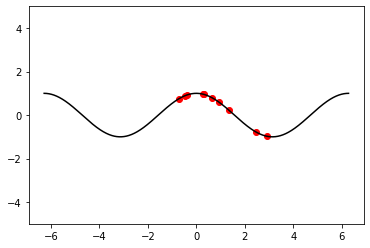

In [ ]:
plt.plot(X_test, Y_test, c='k')
plt.scatter(X, Y, c='r')

plt.ylim([-5., 5.])

## Build Model

In [ ]:
gp_prior, gp_config = rfgp_dist(
    X, lengthscale=1.0, y_noise_std=0.1, l2_regularizer=0.1)

In [ ]:
gp_config

{'units': 1,
 'hidden_units': 128,
 'lengthscale': 1.0,
 'l2_regularizer': 0.1,
 'y_noise_std': 0.1,
 'seed': 0}

In [ ]:
gp_prior.log_prob(gp_prior.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=-473.24152>

## Run MCMC

In [ ]:
samples, _ = run_mcmc(model_dist=gp_prior, y=Y,
                      step_size=.1, num_steps=500, 
                      burnin=100, nchain=4, seed=0)

Acceptance Ratio: 0.7902405858039856


## Examine Posterior.

In [ ]:
# Construct posterior.
posterior_sample = samples[0]  # Shape [num_samples, param_dim]

gp_dist, _ = rfgp_dist(
    X_test, 
    posterior_mode=True, 
    posterior_sample=posterior_sample,
    **gp_config)

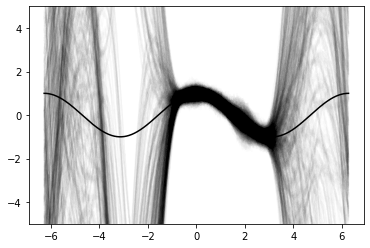

In [ ]:
# Visualize posterior prediction.
y_samples = gp_dist.sample(1000)["y"]

[plt.plot(X_test, sample, alpha=0.01, c='k') for sample in y_samples.numpy()]

plt.plot(X_test, Y_test, c='k')
plt.scatter(X, Y, c='r')

plt.ylim([-5., 5.])
plt.show()

# Full Example: Time Series with BMA, BAE, and BNE

## Data

In [ ]:
N_train = 50  # @param
N_base = 50 # @param  
N_test = 1000  # @param
seed = 0  # @param


In [ ]:
(X_base, X_train, X_test, 
 Y_base, Y_train, Y_test, _) = generate_data_1d(N_train, N_base, N_test, 
                                                y_dist=np.random.lognormal,
                                                seed=seed)

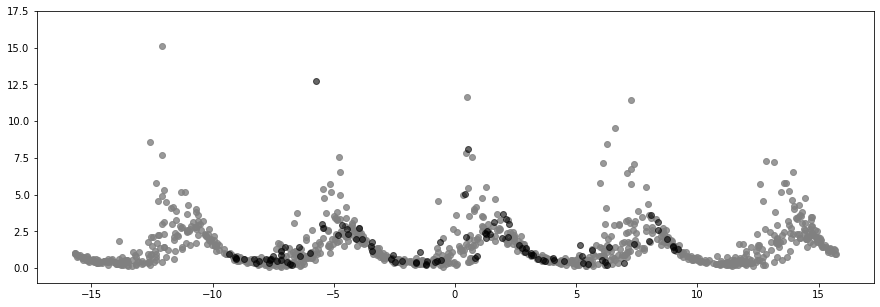

In [ ]:
plot_distribution(X_test, Y_test, loc=None, scale=None,  
                  X_train=X_train, Y_train=Y_train)
plt.ylim(-1, 17.5)
plt.show()

## Base Ensemble Models

In [ ]:
# Specify base models.
kernels = [gpf.kernels.Matern52(lengthscales=0.5), 
           gpf.kernels.Polynomial(degree=3.), 
           gpf.kernels.ArcCosine(weight_variances=1., bias_variance=1.),
           gpf.kernels.Periodic(gpf.kernels.Exponential(lengthscales=2.))]

n_models = len(kernels)
kernel_names = [kernel.name for kernel in kernels]

In [ ]:
models = [
  get_base_prediction(X_base, Y_base, X_train, kernel=k) for k in kernels]
base_preds_train = tf.stack([
  get_base_prediction(X_base, Y_base, X_train, model=m) for m in models], axis=-1)
base_preds_test = tf.stack([
  get_base_prediction(X_base, Y_base, X_test, model=m) for m in models], axis=-1)

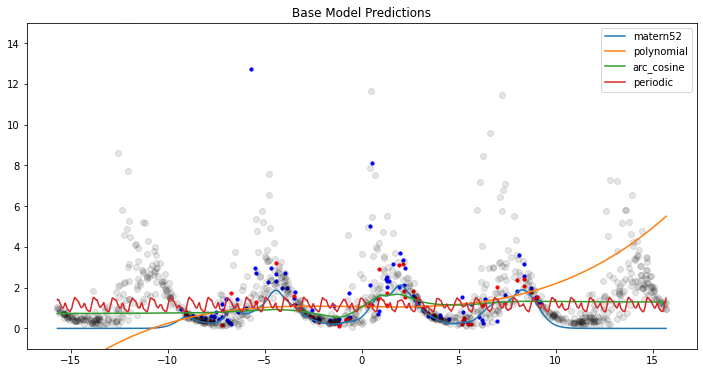

In [ ]:
plt.figure(figsize=(12, 6))

plot_base_models(base_preds_test, kernel_names,
                 X_test, Y_test, X_train, Y_train, X_base, Y_base)

plt.ylim([-1, 15.])
plt.title("Base Model Predictions")
plt.show()

## Bayesian Model Averaging

A Bayesian ensemble model where ensemble weights $w_k's$ are parameterized by Gaussian process priors:

$y \sim N(\mu(x), \sigma^2)$ 

$\mu(x) = \sum_{k=1}^K w_k(x) * m_k(x) \quad$  where $\{m_k\}_{k=1}^K$ are base model predictions.

$w(x) = softmax(f(x)) \qquad\;\;\;$ where $w=[w_1, \dots, w_K]$ and $f=[f_1, \dots, f_K]$

$f \stackrel{i.i.d.}{\sim} GaussianProcess(0, k)$



In [ ]:
# Model configs.
y_noise_std = 0.1  # @param
lengthscale=1.  # @param
l2_regularizer=0.1  # @param

In [ ]:
# MCMC configs.
map_step_size=0.1 # @param
map_num_steps=10_000 # @param

mcmc_step_size=0.1 # @param
mcmc_num_steps=10_000 # @param

In [ ]:
# Posterior configs.
bma_n_samples_train = 100 # @param
bma_n_samples_test = 200 # @param
bma_n_samples_eval = 1000  # @param

bma_seed = 0  # @param
bne_seed = 0 # @param

In [ ]:
# Assemble into configs.
bma_model_config = DEFAULT_GP_CONFIG.copy()
map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()

bma_model_config.update(dict(lengthscale=lengthscale,
                             l2_regularizer=l2_regularizer,
                             y_noise_std=y_noise_std))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))

mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps))

### Build Model

In [ ]:
bma_prior, bma_gp_config = bma_dist(X_train, 
                                    base_preds_train, 
                                    **bma_model_config)

bma_model_config.update(bma_gp_config)

In [ ]:
# Check if the model graph is specified correctly.
bma_prior.resolve_graph()

(('gp_weights', ()), ('y', ('gp_weights',)))

### Run MCMC

In [ ]:
bma_gp_w_samples = run_posterior_inference(model_dist=bma_prior, 
                                           model_config=bma_model_config,
                                           Y=Y_train, 
                                           map_config=map_config,
                                           mcmc_config=mcmc_config)

Running MAP:	14535.923828125...12783.396484375...12781.720703125...12781.5244140625...12781.5234375...12781.5234375...12781.54296875...12781.5419921875...12781.525390625...12781.5615234375...Done.
Running MCMC:	Acceptance Ratio: 0.7340085506439209


In [ ]:
bma_joint_samples = make_bma_samples(X_test, Y_test, base_preds_test, 
                                     bma_weight_samples=bma_gp_w_samples[0],
                                     bma_model_config=bma_model_config, 
                                     n_samples=bma_n_samples_eval, 
                                     seed=bma_seed,
                                     y_samples_only=False)

bma_ensemble_weights = bma_joint_samples['ensemble_weights']
bma_y_samples = bma_joint_samples['y']

### Inspect Posterior

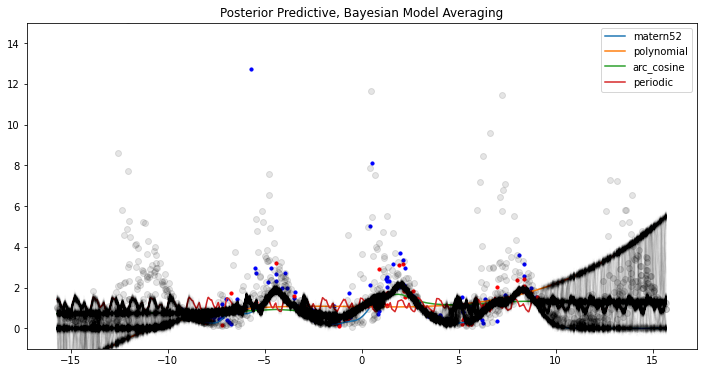

In [ ]:
# Plot posterior prediction.
plt.figure(figsize=(12, 6))

plot_base_models(base_preds_test, kernel_names,
                 X_test, Y_test, X_train, Y_train, X_base, Y_base)

for sample in bma_y_samples:
  plt.plot(X_test, sample, alpha=0.01, c='k')

plt.ylim([-1, 15])
plt.title('Posterior Predictive, Bayesian Model Averaging')
plt.show()

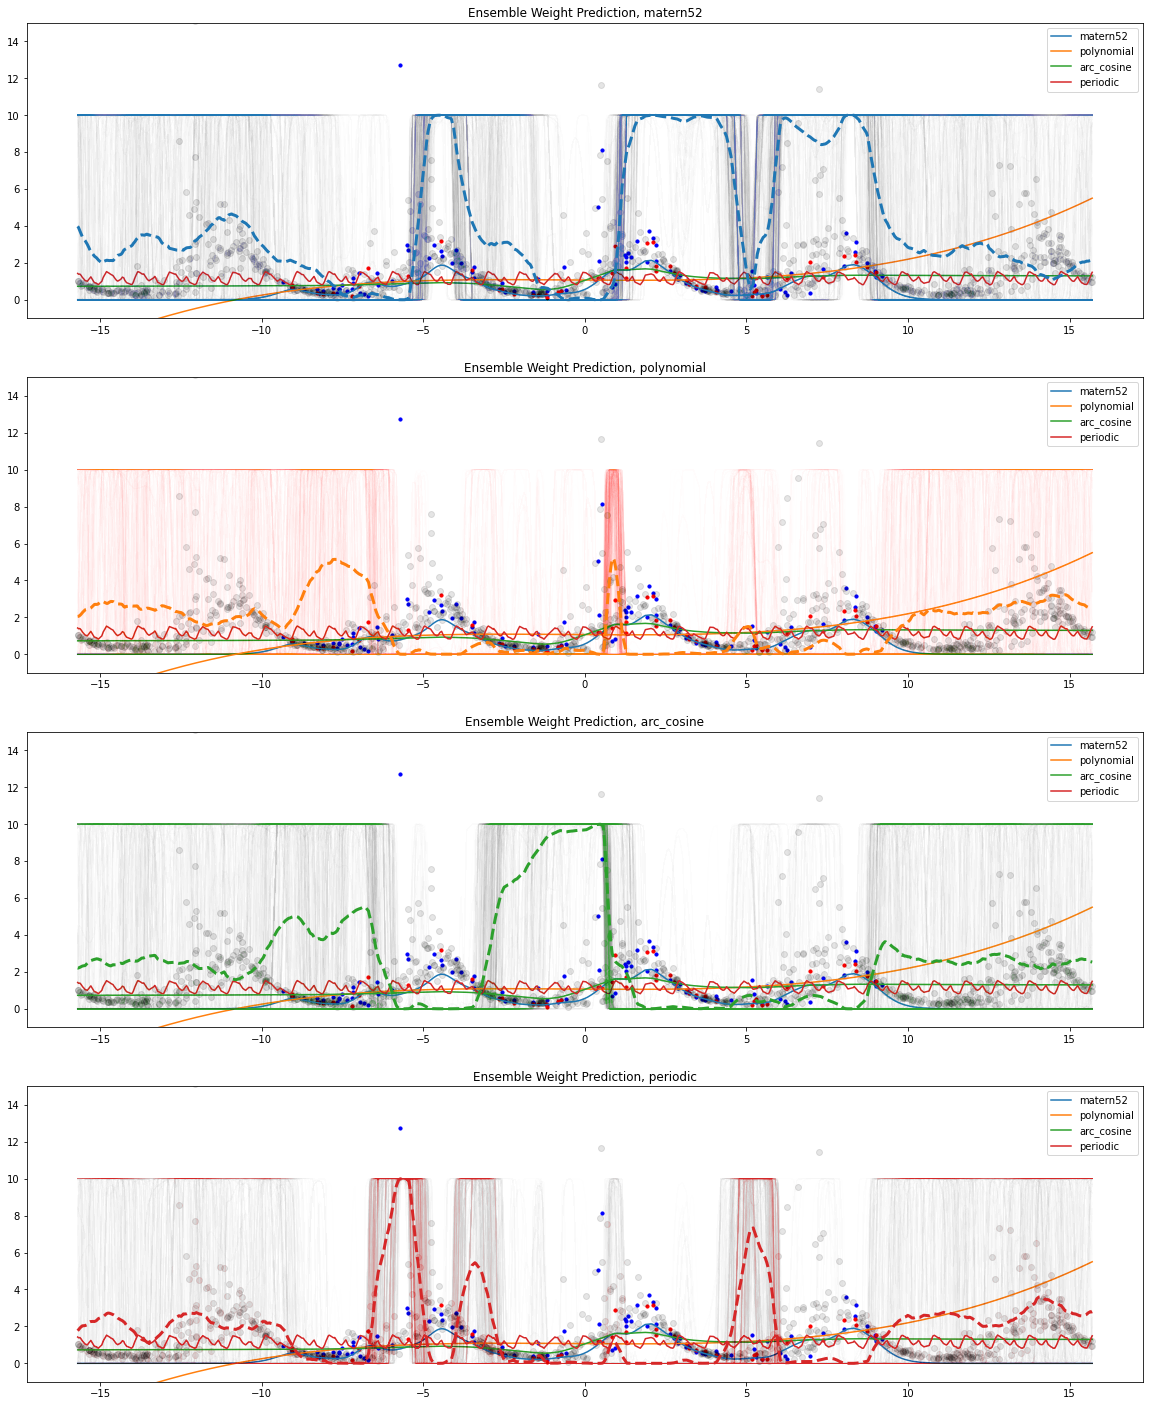

In [ ]:
# Plot posterior ensemble weights for different models.
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(20, 25))

for model_id, model_name in enumerate(kernel_names):
  ax = axes[model_id]
  color = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'][model_id]

  plot_base_models(base_preds_test, kernel_names,
                   X_test, Y_test, X_train, Y_train, X_base, Y_base,
                   ax=ax)

  samples = bma_ensemble_weights[:, :, model_id]
  sample_mean = tf.reduce_mean(samples, axis=0)

  # Plot posterior predictive samples of ensemble weights.
  # Multiply by 10 so it visually more stands out.
  for sample in samples:
    ax.plot(X_test, sample * 10, alpha=0.005, c=color)
  
  # Plot posterior mean of ensemble weights.
  ax.plot(X_test, sample_mean * 10, c=color, 
          linestyle='--', linewidth=3)

  ax.set_ylim([-1., 15.])
  ax.set_title(f'Ensemble Weight Prediction, {model_name}')

plt.show()

### Prepare Data for BAE/BNE

In [ ]:
# Construct data from BMA samples, shapes (num_samples * num_data, ...)
means_train_mcmc, X_train_mcmc, Y_train_mcmc = make_bma_samples(
    X_train, Y_train, base_preds_train, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_train,
    seed=bma_seed, 
    prepare_mcmc_training=True)

# Mean samples based on test data, shape (num_samples, num_data, num_output).
# It is used to generate final examples in `make_bne_samples()`.
means_test_mcmc = make_bma_samples(
    X_test, Y_test, base_preds_test, 
    bma_weight_samples=bma_gp_w_samples[0],
    bma_model_config=bma_model_config,
    n_samples=bma_n_samples_test,
    seed=bma_seed)

## Bayesian Additive Ensemble

Given $\mu(x)$ the posterior of a Bayesian ensemble model, the Bayesian Additive Ensemble is defined as:    

$y \sim N(\mu(x) + r(x), \sigma^2)$

$r \sim GaussianProcess(0, k)$

The additive ensemble $r(x)$ services two purposes: 

1. Mitigates systematic bias in model prediction; 
2. Quantifies the model's epistemic uncertainty.

In [ ]:
# BNE GP Configs.
lengthscale = 1. # @param
l2_regularizer = 10. # @param

# BNE model configs. 
# If estimate_mean=False, only estimates a constant variance on top of the 
# original model.
estimate_mean = "True" # @param ["True", "False"]
variance_prior_mean=0. # @param

In [ ]:
# MAP and MCMC configs
map_step_size=0.1 # @param
map_num_steps=10_000 # @param

mcmc_step_size=1e-2 # @param
mcmc_num_steps=10_000 # @param


In [ ]:
bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=lengthscale, 
                          l2_regularizer=l2_regularizer))
bne_model_config.update(dict(estimate_mean=eval(estimate_mean),
                             variance_prior_mean=variance_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps))

### Define Model

In [ ]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))


### Run MCMC

In [ ]:
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)

Running MAP:	21111.4140625...16290.8388671875...16291.169921875...16290.90234375...16290.8427734375...16290.9091796875...16290.9736328125...16294.8720703125...16290.8662109375...16292.4150390625...Done.
Running MCMC:	Acceptance Ratio: 0.7631127238273621


In [ ]:
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

### Inspect Posterior

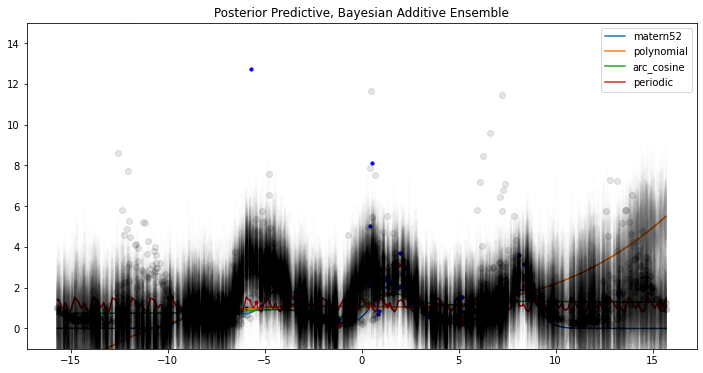

In [ ]:
# Plot raw samples.
plt.figure(figsize=(12, 6))
plot_base_models(base_preds_test, kernel_names,
                 X_test, Y_test, X_train, Y_train, X_base, Y_base)

for sample in bne_joint_samples['y']:
  plt.plot(X_test, sample, alpha=0.01, c='k', linewidth=2)
  plt.ylim([-1, 15])

plt.title('Posterior Predictive, Bayesian Additive Ensemble')
plt.show()

## Bayesian Nonparametric Ensemble (Variance Only)

So far, we are only estimating the mean-component of the model, i.e., we are assuming: 

$y \sim Gaussian(m(x), \sigma^2); \quad m(x) = GP(0, k)$.

By doing so, the model is implicitly assuming the distribution of $y$ is always a symmetric Gaussian distribution with constant mean across space and time. As a result, our model can only quantify model uncertainty (due to lack of data) via the GP prior, but cannot flexibly capture the data uncertainty that is inherent to the empirical distribution of y.

To resolve this, we extend the ensemble's outcome distribution $y | f$ by also estimating the higher moments of the data distribution (e.g., variance, skewness, etc) using flexible estimators. Specifically, we specify the outcome distribution family to the [maximum-entropy distribution](https://en.wikipedia.org/wiki/Principle_of_maximum_entropy) given the known moments, so the predictive distribution is [minimax](https://arxiv.org/pdf/math/0410076.pdf) and still statistically efficient to estimate.

For example, when we want to estimate the first two moments (mean and variance) of the distribution, this leads to a Gaussian distribution with spatio-temporally adaptive variance $\sigma(x)^2$:

$$y \sim Gaussian(m(x), \sigma(x)^2); \quad \mbox{where} \quad m \sim GP(0, k_m), \sigma \sim GP(0, k_\sigma)$$

and when we want to estimate the first three moments (mean and variance) of the distribution, this leads to a [Exponentially-modifed Gaussian](https://en.wikipedia.org/wiki/Exponentially_modified_Gaussian_distribution) (EMG) distribution with spatio-temporally adaptive variance $\sigma(x)^2$ and skewness $\lambda(x)$:

$$y \sim EMG(m(x), \sigma(x)^2, \lambda(x)); \quad \mbox{where} \quad m \sim GP(0, k_m), \sigma \sim GP(0, k_\sigma), \lambda \sim GP(0, k_\lambda)$$



In [ ]:
# BNE GP Configs.
lengthscale = 1. # @param
l2_regularizer = 10. # @param

# BNE model configs.
variance_prior_mean=0. # @param


In [ ]:
# MAP and MCMC configs

map_step_size=5e-3 # @param
map_num_steps=10_000 # @param

mcmc_step_size=1e-2 # @param
mcmc_num_steps=10_000 # @param


In [ ]:
bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=lengthscale, 
                          l2_regularizer=l2_regularizer))
bne_model_config.update(dict(estimate_variance=True,
                             variance_prior_mean=variance_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps))

### Define Model

In [ ]:
# Construct posterior sampler.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

prior model graph: (('gp_weights', ()), ('y', ('gp_weights',)))


### Run MCMC

In [ ]:
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)

Running MAP:	18874.716796875...6632.92578125...6630.689453125...6630.6904296875...6630.6884765625...6630.70068359375...6630.6884765625...6630.68896484375...6630.705078125...6630.6884765625...Done.
Running MCMC:	

In [ ]:
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

### Inspect Posterior

In [ ]:
# Plot raw samples.
plt.figure(figsize=(12, 6))
plot_base_models(base_preds_test, kernel_names,
                 X_test, Y_test, X_train, Y_train, X_base, Y_base)

for sample in bne_joint_samples['y']:
  plt.plot(X_test, sample, alpha=0.01, c='k', linewidth=2)
  plt.ylim(-1, 15)

plt.title('Posterior Predictive, Bayesian Nonparametric Ensemble')
plt.show()

## Bayesian Nonparametric Ensemble (Variance + Skewness)

In [ ]:
# BNE GP Configs.
lengthscale = 1. # @param
l2_regularizer = 10. # @param

# BNE model configs.
variance_prior_mean=0. # @param
skewness_prior_mean=0. # @param

In [ ]:
# MAP and MCMC configs
map_step_size=5e-3 # @param
map_num_steps=10_000 # @param

mcmc_step_size=1e-2 # @param
mcmc_num_steps=10_000 # @param

In [ ]:
bne_gp_config = DEFAULT_GP_CONFIG.copy()
bne_model_config = DEFAULT_BNE_CONFIG.copy()

map_config = DEFAULT_MAP_CONFIG.copy()
mcmc_config = DEFAULT_MCMC_CONFIG.copy()


bne_gp_config.update(dict(lengthscale=lengthscale, 
                          l2_regularizer=l2_regularizer))
bne_model_config.update(dict(estimate_variance=True,
                             estimate_skewness=True,
                             variance_prior_mean=variance_prior_mean,
                             skewness_prior_mean=skewness_prior_mean,
                             **bne_gp_config))

map_config.update(dict(learning_rate=map_step_size,
                       num_steps=map_num_steps))
mcmc_config.update(dict(step_size=mcmc_step_size, 
                        num_steps=mcmc_num_steps))

### Define Model

In [ ]:
# Construct prior distribution.
bne_prior, bne_gp_config = bne_model_dist(
    inputs=X_train_mcmc,
    mean_preds=means_train_mcmc,
    **bne_model_config)

bne_model_config.update(bne_gp_config)
print(f'prior model graph: {bne_prior.resolve_graph()}')

### Run MCMC

In [ ]:
# Estimates GP weight posterior using MCMC.
bne_gp_w_samples = run_posterior_inference(model_dist=bne_prior,
                                           model_config=bne_gp_config,
                                           Y=Y_train_mcmc,
                                           map_config=map_config,
                                           mcmc_config=mcmc_config,
                                           initialize_from_map=True)

In [ ]:
# Generates the posterior sample for all model parameters. 
bne_joint_samples = make_bne_samples(X_test,
                                     mean_preds=means_test_mcmc,
                                     bne_model_config=bne_model_config,
                                     bne_weight_samples=bne_gp_w_samples[0],
                                     seed=bne_seed)

### Inspect Posterior

In [ ]:
# Plot raw samples.
plt.figure(figsize=(12, 6))
plot_base_models(base_preds_test, kernel_names,
                 X_test, Y_test, X_train, Y_train, X_base, Y_base)

for sample in bne_joint_samples['y']:
  plt.plot(X_test, sample, alpha=0.01, c='k', linewidth=2)
  plt.ylim(-1, 15)

plt.title('Posterior Predictive, Bayesian Nonparametric Ensemble')
plt.show()

# Experiment I: 1D Time Series

## Data Configs

Use `DATA_PATH` to specify the Google Drive folder for storing the results. (make sure to create it in Google Drive beforehand). 

In [ ]:
DRIVE_PATH = '/content/drive/'   # @param ['/content/drive/']
DATA_PATH = '/My Drive/BNE_simu'   # @param ['/My Drive/BNE_simu']

FULL_DATA_PATH = f'{DRIVE_PATH}{DATA_PATH[1:]}'
print(f'FULL_DATA_PATH: {FULL_DATA_PATH}')

FULL_DATA_PATH: /content/drive/My Drive/BNE_simu


In [ ]:
N_train_grid = (10, 25, 50, 100, 250, 500, 750, 1000)   # @param
N_base = 50 # @param  
N_test = 1000  # @param
y_dist_name = "lognormal" # @param ["lognormal", "normal", "cauchy"]

num_runs = 100  # @param
num_run_groups = 20   # @param

seed_groups = [range(num_runs)[i:i+num_runs//num_run_groups] for 
               i in range(0, num_runs, num_runs//num_run_groups)]


dist_dict = {'lognormal': np.random.lognormal,
             'normal': np.random.normal,
             'cauchy': lambda m, s: np.random.standard_cauchy(size=(m.shape[0], 1)) * s + m}
y_dist = dist_dict[y_dist_name]

## Model Configs

In [ ]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-3 # @param
map_num_steps=10_000 # @param

mcmc_step_size=1e-3 # @param
mcmc_num_steps=500 # @param

mcmc_nchain=1 # @param
mcmc_burnin=50 # @param
mcmc_initialize_from_map=False # @param


In [ ]:
# BMA parameters.
y_noise_std = 0.1 # @param
bma_gp_lengthscale = 1. # @param
bma_gp_l2_regularizer = 0.1 # @param

bma_n_samples_eval = 100 # @param
bma_n_samples_train = 50 # @param
bma_n_samples_test = 100 # @param
bma_seed = 0 # @param


In [ ]:
# BNE parameters.
bne_gp_lengthscale = 1. # @param
bne_gp_l2_regularizer = 10. # @param
bne_variance_prior_mean = 0. # @param
bne_skewness_prior_mean = 0. # @param
bne_seed = 0 # @param

In [ ]:
bma_config=dict(gp_lengthscale=bma_gp_lengthscale,
                gp_l2_regularizer=bma_gp_l2_regularizer,
                y_noise_std=y_noise_std,
                map_step_size=map_step_size,
                map_num_steps=map_num_steps,
                mcmc_step_size=mcmc_step_size,
                mcmc_num_steps=mcmc_num_steps,
                mcmc_initialize_from_map=mcmc_initialize_from_map,
                n_samples_eval=bma_n_samples_eval, 
                n_samples_train=bma_n_samples_train, 
                n_samples_test=bma_n_samples_test, 
                seed=bma_seed)

bne_config = dict(gp_lengthscale=bne_gp_lengthscale,
                  gp_l2_regularizer=bne_gp_l2_regularizer,
                  variance_prior_mean=bne_variance_prior_mean,
                  skewness_prior_mean=bne_skewness_prior_mean,
                  map_step_size=map_step_size,
                  map_num_steps=map_num_steps,
                  mcmc_step_size=mcmc_step_size,
                  mcmc_num_steps=mcmc_num_steps,
                  mcmc_nchain=mcmc_nchain,
                  mcmc_burnin=mcmc_burnin,
                  mcmc_initialize_from_map=mcmc_initialize_from_map,
                  seed=bne_seed)

## Run Pipeline

In [ ]:
# Configure saving.
drive.mount(DRIVE_PATH, force_remount=True)

tf.io.gfile.makedirs(FULL_DATA_PATH)

Mounted at /content/drive/


In [ ]:
for group_id, seeds in enumerate(seed_groups):
  # if group_id > 1:
  #   continue

  for N_train in N_train_grid:
    print(f'=======Run simulation with n={N_train}, group={group_id}=======')
    # Run pipeline.
    data_dicts = run_pipeline(seeds, N_train, group_id, 
                              data_gen_fn=generate_data_1d)
    save_to_drive(data_dicts, 
                  file_name=f'result_{N_train}_{group_id}', 
                  file_path=FULL_DATA_PATH)
    del data_dicts

=======Run simulation with n=10, group=0=======
Data:Run 1...Run 2...Run 3...Run 4...Run 5...Time: 1.9636 min.
BMA-mean:
Run 1: Running MCMC:	Acceptance Ratio: 0.7330033183097839
Run 2: Running MCMC:	Acceptance Ratio: 0.7259982824325562
Run 3: Running MCMC:	Acceptance Ratio: 0.7327978014945984
Run 4: Running MCMC:	Acceptance Ratio: 0.5500550866127014
Run 5: Running MCMC:	Acceptance Ratio: 0.6150395274162292
Time: 0.9109 min.
BMA:
Run 1: Running MCMC:	Acceptance Ratio: 0.9990448951721191
Run 2: Running MCMC:	Acceptance Ratio: 0.9989943504333496
Run 3: Running MCMC:	Acceptance Ratio: 0.9989253282546997
Run 4: Running MCMC:	Acceptance Ratio: 0.999018669128418
Run 5: Running MCMC:	Acceptance Ratio: 0.9990286827087402
Time: 0.2054 min.
BAE:
Run 1: Running MCMC:	Acceptance Ratio: 0.9990534782409668
Run 2: Running MCMC:	Acceptance Ratio: 0.9990324974060059
Run 3: Running MCMC:	Acceptance Ratio: 0.9989572167396545
Run 4: Running MCMC:	Acceptance Ratio: 0.9990410804748535
Run 5: Running MCMC:	A

## Evaluation


* BAE/BNE models always has better RMSE and Calibration Error.
* BNE-skewness has best coverage probability for 95\% in small sample, and remains competitive has sample size grow.
* BMA has decent coverage probability for $95\%$ only when averaged across the whole dataset but not locally. Therefore may lead to under- or over-estimation of uncertainty depending on the location in the feature space.

In [ ]:
# Compute metrics for all N_train and models. 
metric_rows = []

for N_train in N_train_grid:
  data_dicts = {}
  for group_id in range(len(seed_groups)):
    data_dict_group = load_from_drive(
        f'result_{N_train}_{group_id}', file_path=FULL_DATA_PATH)
    data_dicts.update(data_dict_group)

  for model_name in ('bma', 'bae', 'bne_var', 'bne_skew'):
    metrics = [compute_metrics(data, model_name) for data in data_dicts.values()]
    metrics = np.stack(metrics)
    metric_means = np.mean(metrics, axis=0)
    metric_stds = np.std(metrics, axis=0)

    metric_row = dict(n=N_train, 
                      model_name=model_name, 
                      # Metric means.
                      mse_ind=metric_means[0], 
                      nll_ind=metric_means[1], 
                      clb_ind=metric_means[2], 
                      shp_ind=metric_means[3], 
                      ece_ind=metric_means[4], 
                      cov_prob_95_ind=metric_means[5],
                      mse_all=metric_means[9], 
                      nll_all=metric_means[10], 
                      clb_all=metric_means[11], 
                      shp_all=metric_means[12], 
                      ece_all=metric_means[13], 
                      cov_prob_95_all=metric_means[14],
                      # Metric STDs.
                      mse_ind_std=metric_stds[0], 
                      nll_ind_std=metric_stds[1], 
                      clb_ind_std=metric_stds[2], 
                      shp_ind_std=metric_stds[3], 
                      ece_ind_std=metric_stds[4], 
                      cov_prob_95_ind_std=metric_stds[5],
                      mse_all_std=metric_stds[9], 
                      nll_all_std=metric_stds[10], 
                      clb_all_std=metric_stds[11], 
                      shp_all_std=metric_stds[12], 
                      ece_all_std=metric_stds[13], 
                      cov_prob_95_all_std=metric_stds[14],
                      )
    
    metric_rows.append(metric_row)

In [ ]:
metric_pd = pd.DataFrame(metric_rows)
metric_pd

,n,model_name,nll_ind,mse_ind,ece_ind,cov_prob_95_ind,cov_prob_90_ind,cov_prob_85_ind,cov_prob_80_ind,nll_all,mse_all,ece_all,cov_prob_95_all,cov_prob_90_all,cov_prob_85_all,cov_prob_80_all,nll_ind_std,mse_ind_std,ece_ind_std,cov_prob_95_ind_std,cov_prob_90_ind_std,cov_prob_85_ind_std,cov_prob_80_ind_std,nll_all_std,mse_all_std,ece_all_std,cov_prob_95_all_std,cov_prob_90_all_std,cov_prob_85_all_std,cov_prob_80_all_std
0,10,bma,0.513472,0.423257,0.006433,0.911863,0.888078,0.866374,0.845335,0.631965,1.087868,0.006379,0.91607,0.89355,0.87272,0.85135,0.373421,0.145150,0.002911,0.043830,0.051292,0.057124,0.063108,0.332181,0.355777,0.002653,0.036982,0.043224,0.048337,0.053668
1,10,bae,0.432987,0.260071,0.003732,0.898777,0.869272,0.843670,0.819069,0.628575,0.986682,0.003948,0.90472,0.87856,0.85503,0.83106,0.365674,0.130542,0.002640,0.052176,0.059670,0.064559,0.069431,0.325139,0.378672,0.002386,0.041666,0.047350,0.051945,0.056601
2,10,bne_var,0.545446,0.271357,0.003013,0.897284,0.864893,0.835027,0.805860,0.716582,0.983223,0.003640,0.90151,0.87241,0.84635,0.81964,0.300367,0.117747,0.001843,0.033504,0.040802,0.042888,0.045438,0.208062,0.368087,0.001730,0.020410,0.023848,0.025683,0.027654
3,10,bne_skew,0.277921,0.248598,0.002079,0.924003,0.887711,0.856273,0.823576,0.354021,1.009098,0.002166,0.94507,0.91625,0.88596,0.84831,0.122831,0.147295,0.001014,0.021552,0.027190,0.029887,0.031416,0.075734,0.493742,0.000789,0.012395,0.016167,0.019342,0.023888
4,25,bma,0.407837,0.414642,0.007235,0.927167,0.904668,0.885257,0.866094,0.533596,1.058525,0.007050,0.92808,0.90649,0.88748,0.86780,0.248409,0.131310,0.003162,0.037729,0.045346,0.051633,0.056880,0.249786,0.418516,0.002937,0.034328,0.040419,0.045431,0.049907
5,25,bae,0.320316,0.236897,0.004248,0.915858,0.889020,0.864519,0.841746,0.522806,0.949143,0.004471,0.91737,0.89311,0.87046,0.84789,0.251414,0.102473,0.003303,0.045355,0.053393,0.060715,0.065919,0.252616,0.413678,0.003078,0.039208,0.045101,0.050602,0.055536
6,25,bne_var,0.444121,0.236609,0.002952,0.909152,0.878721,0.851376,0.823000,0.669349,0.931713,0.003725,0.90617,0.87891,0.85379,0.82742,0.224013,0.076706,0.001663,0.027263,0.032571,0.036091,0.039073,0.152749,0.415274,0.001508,0.018337,0.021773,0.024165,0.026154
7,25,bne_skew,0.266857,0.241946,0.002083,0.925225,0.888679,0.857058,0.824879,0.350277,0.951738,0.002191,0.94539,0.91602,0.88455,0.84716,0.099582,0.283402,0.000995,0.019814,0.024215,0.027172,0.028757,0.069275,0.484724,0.001336,0.011723,0.015408,0.018969,0.023060
8,50,bma,0.385197,0.391074,0.007354,0.930905,0.910523,0.893017,0.875555,0.522859,1.047798,0.007138,0.93194,0.91115,0.89349,0.87494,0.265766,0.114735,0.003043,0.033431,0.040167,0.045803,0.051061,0.249604,0.348144,0.002699,0.030001,0.035789,0.040010,0.044435
9,50,bae,0.253751,0.194781,0.004551,0.922669,0.897781,0.875102,0.852582,0.486350,0.929376,0.004613,0.92289,0.89941,0.87820,0.85696,0.229267,0.083543,0.003247,0.040959,0.048834,0.055175,0.060305,0.235371,0.343780,0.002972,0.035383,0.041443,0.046444,0.050331


In [ ]:
metric_pd_1d = metric_pd.copy()
metric_pd_wide = metric_pd_1d[['model_name', 'n', 
                               'mse_ind',	
                               'nll_ind', 'nll_all',
                               'clb_ind', 'clb_all',
                               'shp_ind', 'shp_all',
                               'ece_ind', 'ece_all',
                               'cov_prob_95_ind', 'cov_prob_95_all']]
metric_pd_wide.pivot(index='model_name',columns='n').round(4)

## Visualization

In [ ]:
# @title plot_1d_result
def plot_1d_result(data_dict, model_name='bma'):
  pred_samples = data_dict[f'{model_name}_samples']

  base_preds_test = data_dict['base_preds_test']
  base_model_names = data_dict['base_model_names']
  X_train = data_dict['X_train']
  X_test = data_dict['X_test']
  X_base = data_dict['X_base']
  
  Y_train = data_dict['Y_train']
  Y_test = data_dict['Y_test']
  Y_base = data_dict['Y_base']

  # Plot base models and data.
  plt.figure(figsize=(12, 6))
  plot_base_models(base_preds_test, base_model_names,
                   X_test, Y_test, X_train, Y_train, X_base, Y_base)

  # Plot predictive samples.
  for sample in pred_samples:
    plt.plot(X_test, sample, alpha=0.01, c='k', linewidth=2)
    plt.ylim(-1, 15)

  plt.title(f'Posterior Predictive, {model_name.upper()}')
  plt.show()

In [ ]:
N_train = "1000"  # @param [10, 25, 50, 100, 250, 500, 750, 1000]
group_id = 0  # param

In [ ]:
# Load data from disk and plot it's first run.
data_dicts = load_from_drive(f'result_{N_train}_{group_id}')
data_dict = data_dicts[0]

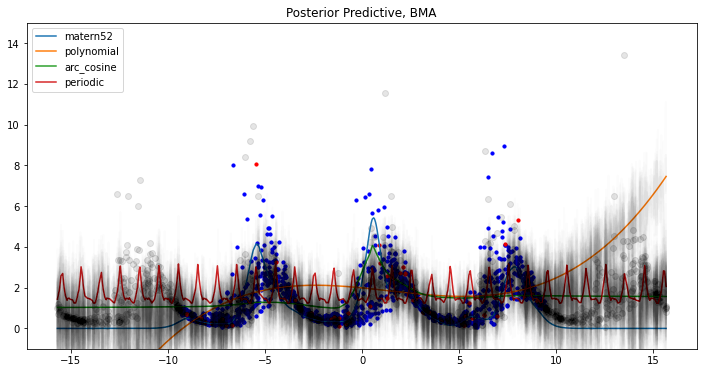

In [ ]:
plot_result(data_dicts[0], model_name='bma')

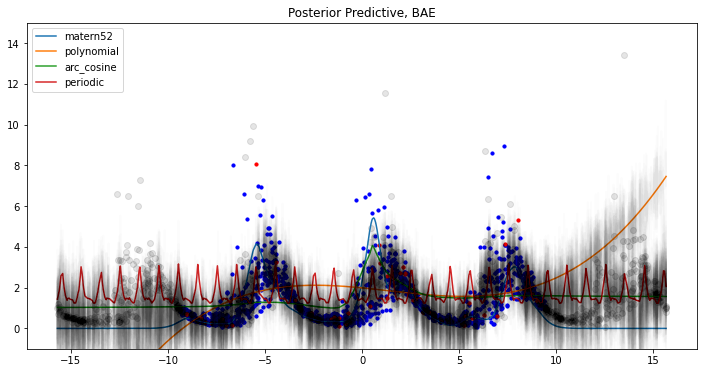

In [ ]:
plot_result(data_dicts[0], model_name='bae')

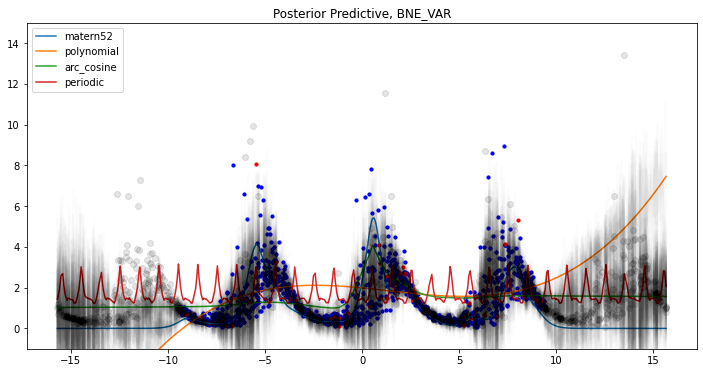

In [ ]:
plot_result(data_dicts[0], model_name='bne_var')

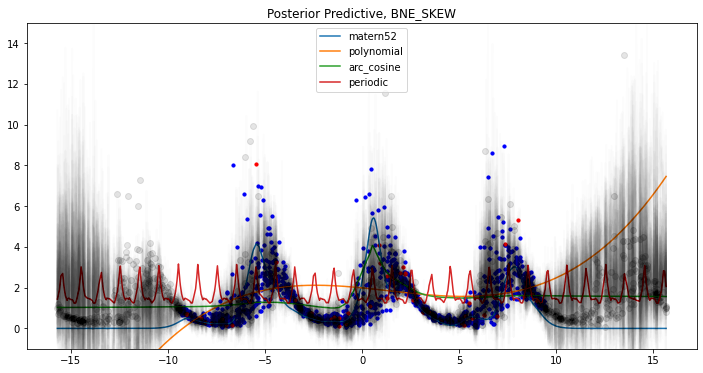

In [ ]:
plot_result(data_dicts[0], model_name='bne_skew')

# Experiment II: 2D Spatial Field

In [ ]:
DRIVE_PATH = '/content/drive/'  
DATA_PATH = '/My Drive/BNE_simu_2d'

FULL_DATA_PATH = os.path.join(DRIVE_PATH, DATA_PATH[1:])
print(f'Files will be saved to {FULL_DATA_PATH}')

Files will be saved to /content/drive/My Drive/BNE_simu_2d


In [ ]:
N_train_grid = (25, 50, 100, 250, 500, 750, 1000)   # @param
N_base = 250 # @param  
N_test = 1000  # @param
y_dist_name = "lognormal" # @param ["lognormal", "normal", "cauchy"]

num_runs =   50# @param
num_run_groups = num_runs // 5   # @param

if num_run_groups > 0:
  seed_groups = [range(num_runs)[i:i+num_runs//num_run_groups] for 
                 i in range(0, num_runs, num_runs//num_run_groups)]
else:
  seed_groups = [list(range(num_runs))]

dist_dict = {'lognormal': np.random.lognormal,
             'normal': np.random.normal,
             'cauchy': lambda m, s: np.random.standard_cauchy(size=(m.shape[0], 1)) * s + m}
y_dist = dist_dict[y_dist_name]

### Model Configs

In [ ]:
# Optimization configs. 
# Consider reduce below parameters / set to `False` if MCMC is taking too long:
# mcmc_num_steps, mcmc_burnin, mcmc_nchain, mcmc_initialize_from_map.
map_step_size=5e-4   # @param
map_num_steps=10_000  # @param

mcmc_step_size=1e-4 # @param
mcmc_num_steps=1000 # @param

mcmc_nchain=1 # @param
mcmc_burnin=100 # @param
bne_mcmc_initialize_from_map="True" # @param ["False", "True"]

bne_mcmc_initialize_from_map = eval(bne_mcmc_initialize_from_map)


In [ ]:
# BMA parameters.
y_noise_std = 0.01  # Note: Changed from 0.1 # @param
bma_gp_lengthscale = 1. # @param
bma_gp_l2_regularizer = 0.1 # @param

bma_n_samples_train = 100 # @param
bma_n_samples_eval = 250 # @param
bma_n_samples_test = 250 # @param
bma_seed = 0 # @param


In [ ]:
# BNE parameters.
bne_gp_lengthscale = 4 # 5. # @param
bne_gp_l2_regularizer = 5 # 15 # @param
bne_variance_prior_mean = -2.5 # @param
bne_skewness_prior_mean = -2.5 # @param
bne_seed = 0 # @param

In [ ]:
bma_config=dict(gp_lengthscale=bma_gp_lengthscale,
                gp_l2_regularizer=bma_gp_l2_regularizer,
                y_noise_std=y_noise_std,
                map_step_size=map_step_size,
                map_num_steps=map_num_steps,
                mcmc_step_size=mcmc_step_size,
                mcmc_num_steps=mcmc_num_steps,
                mcmc_initialize_from_map=False,
                n_samples_eval=bma_n_samples_eval,
                n_samples_train=bma_n_samples_train,
                n_samples_test=bma_n_samples_test,
                seed=bma_seed)

bne_config = dict(gp_lengthscale=bne_gp_lengthscale,
                  gp_l2_regularizer=bne_gp_l2_regularizer,
                  variance_prior_mean=bne_variance_prior_mean,
                  skewness_prior_mean=bne_skewness_prior_mean,
                  map_step_size=map_step_size,
                  map_num_steps=map_num_steps,
                  mcmc_step_size=mcmc_step_size,
                  mcmc_num_steps=mcmc_num_steps,
                  mcmc_nchain=mcmc_nchain,
                  mcmc_burnin=mcmc_burnin,
                  mcmc_initialize_from_map=bne_mcmc_initialize_from_map,
                  seed=bne_seed)

### Run Pipeline

In [ ]:
drive.mount(DRIVE_PATH, force_remount=True)
tf.io.gfile.makedirs(FULL_DATA_PATH)

Mounted at /content/drive/


In [ ]:
#data_dic_sample[5]
for key, value in data_dic_sample[5].items():
    print(key)
print(data_dic_sample[5]["X_base"].shape)
print(data_dic_sample[5]["X_train"].shape)
print(data_dic_sample[5]["X_test"].shape)
print(data_dic_sample[5]["Y_base"].shape)
print(data_dic_sample[5]["Y_train"].shape)
print(data_dic_sample[5]["Y_test"].shape)
print(data_dic_sample[5]["mean_test"].shape)
print(data_dic_sample[5]["base_preds_train"].shape)
print(data_dic_sample[5]["base_preds_test"].shape)
print(data_dic_sample[5]["base_model_names"])
print(data_dic_sample[5]["bne_var_samples"])

X_base
X_train
X_test
Y_base
Y_train
Y_test
mean_test
base_preds_train
base_preds_test
base_model_names
X_train_mcmc
Y_train_mcmc
means_train_mcmc
means_test_mcmc
bma_mean_samples
bma_samples
bae_samples
bne_var_samples
bne_skew_samples
(250, 2)
(275, 2)
(1000, 2)
(250, 1)
(275, 1)
(1000, 1)
(1000, 1)
(275, 4)
(1000, 4)
['matern52', 'polynomial', 'arc_cosine', 'periodic']
tf.Tensor(
[[[0.7371056 ]
  [0.8532426 ]
  [0.9923396 ]
  ...
  [0.8337894 ]
  [0.90668714]
  [0.905321  ]]

 [[0.8705911 ]
  [0.88402927]
  [0.92631495]
  ...
  [0.853946  ]
  [0.81810796]
  [0.7917757 ]]

 [[0.9045079 ]
  [0.850354  ]
  [0.9691226 ]
  ...
  [0.834592  ]
  [0.8293159 ]
  [0.8274458 ]]

 ...

 [[0.81510293]
  [0.8074828 ]
  [0.97887313]
  ...
  [0.8811068 ]
  [0.8785864 ]
  [0.845051  ]]

 [[0.90368736]
  [0.81433976]
  [1.0699185 ]
  ...
  [0.8582117 ]
  [0.8318827 ]
  [0.8423555 ]]

 [[0.83797586]
  [0.82583594]
  [0.9858624 ]
  ...
  [0.84585744]
  [0.82423246]
  [0.9032619 ]]], shape=(250, 1000, 1

In [ ]:
for group_id, seeds in enumerate(seed_groups):        
  for N_train in N_train_grid:
    print(f'=======Run simulation with n={N_train}, group={group_id}=======')
    # Run pipeline.
    data_dicts = run_pipeline(seeds, N_train, group_id, 
                              data_gen_fn=generate_data_2d,
                              base_train_steps=200)

    save_to_drive(data_dicts, 
                  file_name=f'result_{N_train}_{group_id}', 
                  file_path=FULL_DATA_PATH)


=======Run simulation with n=25, group=0=======
Data:Run 1...Run 2...Run 3...Run 4...Run 5...Time: 1.8476 min.
BMA-mean:
Run 1: Running MCMC:	Acceptance Ratio: 0.6809126734733582
Run 2: Running MCMC:	Acceptance Ratio: 0.6497206091880798
Run 3: Running MCMC:	Acceptance Ratio: 0.6145690083503723
Run 4: Running MCMC:	Acceptance Ratio: 0.6284807324409485
Run 5: Running MCMC:	Acceptance Ratio: 0.6304741501808167
Time: 1.4942 min.
BMA:
Run 1: Running MCMC:	Acceptance Ratio: 0.9979217648506165
Run 2: Running MCMC:	Acceptance Ratio: 0.9977936744689941
Run 3: Running MCMC:	Acceptance Ratio: 0.9977395534515381
Run 4: Running MCMC:	Acceptance Ratio: 0.9979445934295654
Run 5: Running MCMC:	Acceptance Ratio: 0.9979260563850403
Time: 0.6060 min.
BAE:
Run 1: Running MAP:	-29539.912109375...-53120.94140625...-60081.11328125...-62105.546875...-62330.953125...-62386.1640625...-62419.05859375...-62444.16796875...-62462.95703125...-62476.875...Done.
Running MCMC:	Acceptance Ratio: 0.8719930052757263
Run 2

### Evaluation

In [ ]:
# Compute metrics for all N_train and models. 
metric_rows = []

for N_train in N_train_grid:
  data_dicts = {}
  for group_id in range(len(seed_groups)):
    data_dict_group = load_from_drive(
        f'result_{N_train}_{group_id}', file_path=FULL_DATA_PATH)
    data_dicts.update(data_dict_group)

  for model_name in ('bma', 'bae', 'bne_var', 'bne_skew'):
    metrics = [compute_metrics(data, model_name, num_sample=50) 
               for data in data_dicts.values()]
    metrics = np.stack(metrics)
    metric_means = np.mean(metrics, axis=0)
    metric_stds = np.std(metrics, axis=0)

    metric_row = dict(n=N_train, 
                      model_name=model_name, 
                      # Metric means.
                      mse_ind=metric_means[0], 
                      nll_ind=metric_means[1], 
                      clb_ind=metric_means[2], 
                      shp_ind=metric_means[3], 
                      ece_ind=metric_means[4], 
                      cov_prob_95_ind=metric_means[5],
                      mse_all=metric_means[9], 
                      nll_all=metric_means[10], 
                      clb_all=metric_means[11], 
                      shp_all=metric_means[12], 
                      ece_all=metric_means[13], 
                      cov_prob_95_all=metric_means[14],
                      # Metric STDs.
                      mse_ind_std=metric_stds[0], 
                      nll_ind_std=metric_stds[1], 
                      clb_ind_std=metric_stds[2], 
                      shp_ind_std=metric_stds[3], 
                      ece_ind_std=metric_stds[4], 
                      cov_prob_95_ind_std=metric_stds[5],
                      mse_all_std=metric_stds[9], 
                      nll_all_std=metric_stds[10], 
                      clb_all_std=metric_stds[11], 
                      shp_all_std=metric_stds[12], 
                      ece_all_std=metric_stds[13], 
                      cov_prob_95_all_std=metric_stds[14],
                      )
    
    metric_rows.append(metric_row)

In [ ]:
metric_pd = pd.DataFrame(metric_rows)
metric_pd

,n,model_name,mse_ind,nll_ind,clb_ind,shp_ind,ece_ind,cov_prob_95_ind,mse_all,nll_all,...,clb_ind_std,shp_ind_std,ece_ind_std,cov_prob_95_ind_std,mse_all_std,nll_all_std,clb_all_std,shp_all_std,ece_all_std,cov_prob_95_all_std
0,25,bma,0.257128,-2.718467,0.718067,-3.436535,0.006515,0.941330,1.340870,-2.276960,...,0.093830,0.014751,0.001730,0.012988,0.218361,0.074117,0.066058,0.040625,0.003735,0.013746
1,25,bae,0.195051,-2.908541,0.603616,-3.512157,0.004743,0.951975,1.576637,-2.414264,...,0.081364,0.024955,0.001292,0.013370,0.427727,0.045045,0.037051,0.046345,0.002158,0.013333
2,25,bne_var,0.194066,-2.947252,0.605613,-3.552864,0.004688,0.952562,1.739536,-2.425409,...,0.087952,0.024838,0.001135,0.010891,0.436688,0.057615,0.056713,0.044070,0.001849,0.014442
3,25,bne_skew,0.190124,-2.960927,0.581475,-3.542403,0.004637,0.959178,1.502245,-2.460568,...,0.077329,0.026770,0.001210,0.006872,0.397025,0.056840,0.058321,0.046192,0.001550,0.014347
4,50,bma,0.256431,-2.715036,0.733212,-3.448248,0.006840,0.936170,1.441965,-2.252437,...,0.071718,0.022977,0.001792,0.015816,0.308104,0.054941,0.066927,0.040672,0.004440,0.018554
5,50,bae,0.193148,-2.904076,0.619486,-3.523562,0.005070,0.948343,1.681062,-2.400871,...,0.064477,0.025626,0.001288,0.011596,0.520001,0.063863,0.071502,0.045157,0.003098,0.018734
6,50,bne_var,0.192446,-2.942047,0.621382,-3.563430,0.005099,0.949273,1.799937,-2.424841,...,0.069471,0.024248,0.001067,0.009433,0.500845,0.061304,0.054858,0.039057,0.002341,0.014859
7,50,bne_skew,0.192851,-2.949167,0.599212,-3.548379,0.004852,0.954439,1.527876,-2.459692,...,0.069821,0.029340,0.001169,0.011370,0.453329,0.068123,0.058436,0.039506,0.002039,0.015781
8,100,bma,0.250732,-2.701172,0.740948,-3.442120,0.006763,0.937891,1.325294,-2.254179,...,0.116658,0.031559,0.001557,0.017090,0.115572,0.090249,0.105519,0.049600,0.004187,0.024630
9,100,bae,0.189512,-2.901439,0.618416,-3.519855,0.004925,0.947571,1.620961,-2.390059,...,0.091776,0.032983,0.001259,0.012246,0.426741,0.083990,0.094733,0.053421,0.002556,0.013905


In [ ]:
metric_pd_2d = metric_pd.copy()
metric_pd_wide = metric_pd_2d[['model_name', 'n', 
                               # 'mse_ind',	
                               'nll_ind', 'nll_all',
                               'clb_ind', 'clb_all',
                               'shp_ind', 'shp_all',
                               'ece_ind', 'ece_all',
                               'cov_prob_95_ind', 'cov_prob_95_all']]
metric_pd_wide.pivot(index='model_name',columns='n').round(4)

nll_ind                                                 nll_all  \
n             25      50      100     250     500     750     1000    25     
model_name                                                                   
bae        -2.9085 -2.9041 -2.9014 -2.9369 -2.9919 -3.0142 -3.0332 -2.4143   
bma        -2.7185 -2.7150 -2.7012 -2.7662 -2.8025 -2.8372 -2.8615 -2.2770   
bne_skew   -2.9609 -2.9492 -2.9585 -3.0208 -3.0611 -3.0660 -3.1046 -2.4606   
bne_var    -2.9473 -2.9420 -2.9547 -3.0024 -3.0403 -3.0672 -3.0894 -2.4254   

                            ... cov_prob_95_ind                  \
n             50      100   ...            500     750     1000   
model_name                  ...                                   
bae        -2.4009 -2.3901  ...          0.9602  0.9635  0.9593   
bma        -2.2524 -2.2542  ...          0.9491  0.9508  0.9489   
bne_skew   -2.4597 -2.4620  ...          0.9691  0.9701  0.9687   
bne_var    -2.4248 -2.4204  ...          0.9652  0.9650  0.9622   

           cov_prob_95_all                                                  
n                     25      50      100     250     500     750     1000  
model_name                                                                  
bae                 0.8812  0.8828  0.8788  0.8846  0.8958  0.8998  0.8954  
bma                 0.8712  0.8704  0.8714  0.8744  0.8864  0.8898  0.8816  
bne_skew            0.9344  0.9356  0.9372  0.9438  0.9440  0.9408  0.9422  
bne_var             0.8988  0.9030  0.9008  0.9052  0.9106  0.9148  0.9118  

[4 rows x 70 columns]